<a href="https://colab.research.google.com/github/MoonJaeHoon/Dacon_Behavioral_Data_Analysis/blob/master/Ch5.1_%EB%AA%A8%EB%8D%B8%EB%A7%8138_RF_PermutationImportance_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**차례**
## 1. Player1-Player0=diff 변수 생성
## 2. Permutation Importance 방법론을 이용한 변수선택
## 3. 베이지안 최적화 Optuna 라이브러리를 이용한 LGBM 파라미터 튜닝

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install optuna==0.18.1

     |████████████████████████████████| 122kB 2.8MB/s 
     |████████████████████████████████| 1.1MB 6.8MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 81kB 7.3MB/s 
     |████████████████████████████████| 81kB 8.6MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 112kB 15.3MB/s 
     |████████████████████████████████| 61kB 7.6MB/s 
  Created wheel for alembic: filename=alembic-1.4.2-cp36-none-any.whl size=159543 sha256=84c0b968fa85bba8f1f4f103304f6cf0fb332a2662758331e65336a529ae0b5c
  Stored in directory: /root/.cache/pip/wheels/1f/04/83/76023f7a4c14688c0b5c2682a96392cfdd3ee4449eaaa287ef
Successfully built alembic
  Created wheel for optuna: filename=optuna-0.18.1-cp36-none-any.whl size=165106 sha256=14ac9d44c5fbd5feda1cf3888e57c347bb8aee0c58035dd42347a9bae9b5f964
  Stored in directory: /root/.cache/pip/wheels/40/d

In [3]:
import os
print( '변경 전 기본 경로 :' )
print(  os.getcwd() )
os.chdir('./drive/My Drive/데이콘_게임데이터분석')
print( '변경 후 파일 경로 :' )
print(  os.getcwd()  )


import optuna                               # 베이지안 최적화 라이브러리  
from optuna import Trial
import gc
debug = False
import numpy as np
import pandas as pd

from tqdm import tqdm_notebook              # 진행바
from sklearn.metrics import roc_auc_score   # AUC 스코어 계산
from sklearn.model_selection import KFold   # K-fold CV    
from functools import partial               # 함수 변수 고정
import lightgbm as lgb                      # LightGBM 라이브러리
import warnings                             
warnings.filterwarnings("ignore")           # 경고 문구 미표시
%time
train16 = pd.read_pickle('train16.pkl')

%time
test16 = pd.read_pickle('test16.pkl')

변경 전 기본 경로 :
/content
변경 후 파일 경로 :
/content/drive/My Drive/데이콘_게임데이터분석
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


# 1. Player1-Player0=diff 변수 생성

## Train Set diff생성 (apply 적용)

In [0]:
######################################### 종족 인코딩하기 ########################################
def spec_convert(x):
    if x[0] == 'Z':
        return 2
    elif x[0] == 'P':
        return 1
    else:
        return 0

train16['P0_species']=train16.apply(lambda x: spec_convert(x['P0_species']),axis=1)
train16['P1_species']=train16.apply(lambda x: spec_convert(x['P1_species']),axis=1)

################################ 결측치가 있는 column & 사용 안할 column들 제거해놓기 ######################
no_missing_train0 = train16.drop(['player0_starting_category','player1_starting_category','player0_center_x','player0_center_y','player1_center_x','player1_center_y',]
                                , axis=1)

################################## 종족이라는 변수는 빼고 P0와 P1간의 차이를 구할 거기 때문에 ##########################
columns = pd.Series(no_missing_train0.columns)
columns.index = no_missing_train0.columns.tolist()
columns = columns.drop(['P0_species','P1_species','map'])
columns = columns.tolist()

#################### 범주형 변수들 ################# (종족은 순서형으로 봐야될지도 확인ㄱㄱㄱ)
cat_features = ['P0_species','P1_species','map']

####################### P0를 포함하는 컬럼, P1을 포함하는 컬럼 #################################
p0_columns = [c for c in columns if c.startswith('P0_')]
p1_columns = [c for c in columns if c.startswith('P1_')]

####################################### diff변수 생성 전에 루트변환? (카운팅은 높을수록 서로간의 차이가 의미가 없으므로) ##############################
from math import log
from math import sqrt
import re
diff_feat_list = []

for rawfeat0, rawfeat1 in zip(p0_columns,p1_columns):
  #no_missing_train0[rawfeat0]  =  no_missing_train0.apply(lambda x: sqrt(x[rawfeat0]),axis=1) 
  #no_missing_train0[rawfeat1]  =  no_missing_train0.apply(lambda x: sqrt(x[rawfeat1]),axis=1) 
  diff_feat = 'diff_'+ re.sub('P0_','', rawfeat0)
  diff_feat_list.append(diff_feat)
  no_missing_train0[diff_feat]  =  no_missing_train0.apply(lambda x: (x[rawfeat1]-x[rawfeat0]), axis=1)

################################# diff 변수 생성 후 본래 P0, P1 컬럼 없애기 #######################

#no_missing_train0 = no_missing_train0.drop(p0_columns+p1_columns,axis=1)

no_missing_train0.describe()


,P0_Ability_bytime_0,P0_Ability_bytime_2,P0_Ability_bytime_4,P0_Ability_bytime_6,P0_Ability_bytime_8,P0_Ability_bytime_10,P0_AddToControlGroup_bytime_0,P0_AddToControlGroup_bytime_2,P0_AddToControlGroup_bytime_4,P0_AddToControlGroup_bytime_6,P0_AddToControlGroup_bytime_8,P0_AddToControlGroup_bytime_10,P0_Camera_bytime_0,P0_Camera_bytime_2,P0_Camera_bytime_4,P0_Camera_bytime_6,P0_Camera_bytime_8,P0_Camera_bytime_10,P0_ControlGroup_bytime_0,P0_ControlGroup_bytime_2,P0_ControlGroup_bytime_4,P0_ControlGroup_bytime_6,P0_ControlGroup_bytime_8,P0_ControlGroup_bytime_10,P0_GetControlGroup_bytime_0,P0_GetControlGroup_bytime_2,P0_GetControlGroup_bytime_4,P0_GetControlGroup_bytime_6,P0_GetControlGroup_bytime_8,P0_GetControlGroup_bytime_10,P0_Right Click_bytime_0,P0_Right Click_bytime_2,P0_Right Click_bytime_4,P0_Right Click_bytime_6,P0_Right Click_bytime_8,P0_Right Click_bytime_10,P0_Selection_bytime_0,P0_Selection_bytime_2,P0_Selection_bytime_4,P0_Selection_bytime_6,...,diff_Click_Resources_bytime_4,diff_Click_Resources_bytime_6,diff_Click_Resources_bytime_8,diff_Click_Resources_bytime_10,diff_Click_DSC_bytime_0,diff_Click_DSC_bytime_2,diff_Click_DSC_bytime_4,diff_Click_DSC_bytime_6,diff_Click_DSC_bytime_8,diff_Click_DSC_bytime_10,diff_Click_DSG_bytime_0,diff_Click_DSG_bytime_2,diff_Click_DSG_bytime_4,diff_Click_DSG_bytime_6,diff_Click_DSG_bytime_8,diff_Click_DSG_bytime_10,diff_Click_DSF_bytime_0,diff_Click_DSF_bytime_2,diff_Click_DSF_bytime_4,diff_Click_DSF_bytime_6,diff_Click_DSF_bytime_8,diff_Click_DSF_bytime_10,diff_Click_COB_bytime_0,diff_Click_COB_bytime_2,diff_Click_COB_bytime_4,diff_Click_COB_bytime_6,diff_Click_COB_bytime_8,diff_Click_COB_bytime_10,diff_Click_Gas_bytime_0,diff_Click_Gas_bytime_2,diff_Click_Gas_bytime_4,diff_Click_Gas_bytime_6,diff_Click_Gas_bytime_8,diff_Click_Gas_bytime_10,diff_Click_Multi_bytime_0,diff_Click_Multi_bytime_2,diff_Click_Multi_bytime_4,diff_Click_Multi_bytime_6,diff_Click_Multi_bytime_8,diff_Click_Multi_bytime_10
count,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,...,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000,38872.000000
mean,7.431467,18.142236,30.575427,41.003627,48.476178,48.806467,0.457502,0.881251,1.297361,1.643934,1.904996,1.918450,79.440214,179.542781,273.952794,349.860774,404.903530,407.357918,0.116948,0.203437,0.286324,0.351358,0.393908,0.396275,43.751595,80.108690,103.278787,119.119855,129.067735,129.523307,29.220416,64.809066,99.850587,128.037868,148.046975,148.942118,31.815265,59.001441,84.699681,106.646404,...,-0.177634,-0.173570,-0.168733,-0.167550,-0.076070,-0.090193,-0.085897,-0.085537,-0.087647,-0.085897,-0.002444,-0.000412,-0.000463,-0.000180,0.000077,0.000077,0.000309,-0.005968,-0.004193,-0.002727,-0.005402,-0.005377,-0.000720,-0.001055,-0.001106,-0.001363,-0.000900,-0.001080,0.000412,-0.026497,-0.013069,-0.015127,-0.025777,-0.023950,-0.001132,-0.012014,-0.017313,-0.023282,-0.037533,-0.038537
std,2.544722,6.314469,13.162384,20.721461,27.707051,28.119083,0.937607,1.435750,2.003790,2.540955,3.009919,3.038626,46.618459,86.199005,128.840126,175.399127,219.76264

## Test Set diff생성 (apply 적용)

In [0]:


test16['P0_species']=test16.apply(lambda x: spec_convert(x['P0_species']),axis=1)
test16['P1_species']=test16.apply(lambda x: spec_convert(x['P1_species']),axis=1)

################################ 결측치가 있는 column & 사용 안할 column들 제거해놓기 ######################
no_missing_test = test16.drop(['player0_starting_category','player1_starting_category','player0_center_x','player0_center_y','player1_center_x','player1_center_y',]
                                , axis=1)

################################## 종족이라는 변수는 빼고 P0와 P1간의 차이를 구할 거기 때문에 ##########################
columns = pd.Series(no_missing_test.columns)
columns.index = no_missing_test.columns.tolist()
columns = columns.drop(['P0_species','P1_species','map'])
columns = columns.tolist()

#################### 범주형 변수들 ################# (종족은 순서형으로 봐야될지도 확인ㄱㄱㄱ)
cat_features = ['P0_species','P1_species','map']

####################### P0를 포함하는 컬럼, P1을 포함하는 컬럼 #################################
p0_columns = [c for c in columns if c.startswith('P0_')]
p1_columns = [c for c in columns if c.startswith('P1_')]

####################################### diff변수 생성 전에 루트변환? (카운팅은 높을수록 서로간의 차이가 의미가 없으므로) ##############################
from math import log
from math import sqrt
import re
diff_feat_list = []

for rawfeat0, rawfeat1 in zip(p0_columns,p1_columns):
  #no_missing_test[rawfeat0]  =  no_missing_test.apply(lambda x: sqrt(x[rawfeat0]),axis=1) 
  #no_missing_test[rawfeat1]  =  no_missing_test.apply(lambda x: sqrt(x[rawfeat1]),axis=1) 
  diff_feat = 'diff_'+ re.sub('P0_','', rawfeat0)
  diff_feat_list.append(diff_feat)
  no_missing_test[diff_feat]  =  no_missing_test.apply(lambda x: (x[rawfeat1]-x[rawfeat0]), axis=1)

################################# diff 변수 생성 후 본래 P0, P1 컬럼 없애기 #######################

#no_missing_test = no_missing_test.drop(p0_columns+p1_columns,axis=1)

no_missing_test.describe()

,P0_Ability_bytime_0,P0_Ability_bytime_2,P0_Ability_bytime_4,P0_Ability_bytime_6,P0_Ability_bytime_8,P0_Ability_bytime_10,P0_AddToControlGroup_bytime_0,P0_AddToControlGroup_bytime_2,P0_AddToControlGroup_bytime_4,P0_AddToControlGroup_bytime_6,P0_AddToControlGroup_bytime_8,P0_AddToControlGroup_bytime_10,P0_Camera_bytime_0,P0_Camera_bytime_2,P0_Camera_bytime_4,P0_Camera_bytime_6,P0_Camera_bytime_8,P0_Camera_bytime_10,P0_ControlGroup_bytime_0,P0_ControlGroup_bytime_2,P0_ControlGroup_bytime_4,P0_ControlGroup_bytime_6,P0_ControlGroup_bytime_8,P0_ControlGroup_bytime_10,P0_GetControlGroup_bytime_0,P0_GetControlGroup_bytime_2,P0_GetControlGroup_bytime_4,P0_GetControlGroup_bytime_6,P0_GetControlGroup_bytime_8,P0_GetControlGroup_bytime_10,P0_Right Click_bytime_0,P0_Right Click_bytime_2,P0_Right Click_bytime_4,P0_Right Click_bytime_6,P0_Right Click_bytime_8,P0_Right Click_bytime_10,P0_Selection_bytime_0,P0_Selection_bytime_2,P0_Selection_bytime_4,P0_Selection_bytime_6,...,diff_Click_Resources_bytime_4,diff_Click_Resources_bytime_6,diff_Click_Resources_bytime_8,diff_Click_Resources_bytime_10,diff_Click_DSC_bytime_0,diff_Click_DSC_bytime_2,diff_Click_DSC_bytime_4,diff_Click_DSC_bytime_6,diff_Click_DSC_bytime_8,diff_Click_DSC_bytime_10,diff_Click_DSG_bytime_0,diff_Click_DSG_bytime_2,diff_Click_DSG_bytime_4,diff_Click_DSG_bytime_6,diff_Click_DSG_bytime_8,diff_Click_DSG_bytime_10,diff_Click_DSF_bytime_0,diff_Click_DSF_bytime_2,diff_Click_DSF_bytime_4,diff_Click_DSF_bytime_6,diff_Click_DSF_bytime_8,diff_Click_DSF_bytime_10,diff_Click_COB_bytime_0,diff_Click_COB_bytime_2,diff_Click_COB_bytime_4,diff_Click_COB_bytime_6,diff_Click_COB_bytime_8,diff_Click_COB_bytime_10,diff_Click_Gas_bytime_0,diff_Click_Gas_bytime_2,diff_Click_Gas_bytime_4,diff_Click_Gas_bytime_6,diff_Click_Gas_bytime_8,diff_Click_Gas_bytime_10,diff_Click_Multi_bytime_0,diff_Click_Multi_bytime_2,diff_Click_Multi_bytime_4,diff_Click_Multi_bytime_6,diff_Click_Multi_bytime_8,diff_Click_Multi_bytime_10
count,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,...,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000,16787.000000
mean,7.397093,18.054506,30.386251,40.770001,48.218443,48.555370,0.455769,0.871806,1.268482,1.616787,1.875499,1.890808,78.856794,177.903854,271.117114,346.411688,401.124561,403.682909,0.106630,0.189968,0.256806,0.317925,0.354143,0.355573,43.645083,79.851671,103.034551,118.883839,128.676655,129.127539,28.681897,63.964913,98.407994,125.920653,145.428248,146.354560,31.637517,58.551736,83.817418,105.423065,...,0.025555,0.025794,0.027283,0.029606,0.177459,0.166379,0.148091,0.181390,0.232025,0.234527,-0.007744,-0.012152,-0.012986,-0.013582,-0.015309,-0.015190,0.013284,0.013820,0.020611,0.027819,0.027283,0.027760,-0.001251,-0.005123,-0.004468,-0.004885,-0.006851,-0.006910,0.016620,0.036576,0.010365,0.008697,0.012986,0.012986,-0.003991,-0.013225,-0.012569,-0.010663,-0.013999,-0.013225
std,2.508546,6.371016,13.239429,20.869773,27.932083,28.336043,0.950581,1.444310,1.980799,2.506156,2.973309,3.006079,46.622121,86.519787,129.884928,177.331645,221.733792,224.468756,1.115

In [0]:
train_Ability_Raw = pd.read_pickle('train_Ability_Raw.pkl')
test_Ability_Raw = pd.read_pickle('test_Ability_Raw.pkl')
train_Ability = pd.read_pickle('train_Ability.pkl')
test_Ability = pd.read_pickle('test_Ability.pkl')
train_Selection_Raw = pd.read_pickle('train_Selection_Raw.pkl')
test_Selection_Raw = pd.read_pickle('test_Selection_Raw.pkl')
train_Selection = pd.read_pickle('train_Selection.pkl')
test_Selection = pd.read_pickle('test_Selection.pkl')
train_Right_Raw = pd.read_pickle('train_Right_Raw.pkl')
test_Right_Raw = pd.read_pickle('test_Right_Raw.pkl')
train_Right = pd.read_pickle('train_Right.pkl')
test_Right = pd.read_pickle('test_Right.pkl')
#train_Camera = pd.read_pickle('train_Camera_10단위.pkl')
#test_Camera = pd.read_pickle('test_Camera_10단위.pkl')

train_Ability_Raw = train_Ability_Raw.add_prefix('Ability_Raw_')
test_Ability_Raw = test_Ability_Raw.add_prefix('Ability_Raw_')
train_Selection_Raw = train_Selection_Raw.add_prefix('Selection_Raw_')
test_Selection_Raw = test_Selection_Raw.add_prefix('Selection_Raw_')
train_Right_Raw = train_Right_Raw.add_prefix('Right_Raw_')
test_Right_Raw = test_Right_Raw.add_prefix('Right_Raw_')

train_Ability = train_Ability.add_prefix('Ability_')
test_Ability = test_Ability.add_prefix('Ability_')
train_Selection = train_Selection.add_prefix('Selection_')
test_Selection = test_Selection.add_prefix('Selection_')
train_Right = train_Right.add_prefix('Right_')
test_Right = test_Right.add_prefix('Right_')

print(train_Ability_Raw.shape)
print(train_Ability.shape)
print(train_Selection_Raw.shape)
print(train_Selection.shape)
print(train_Right_Raw.shape)
print(train_Right.shape)


(38872, 1507)
(38872, 936)
(38872, 2491)
(38872, 341)
(38872, 1552)
(38872, 336)


# 2. Permutation Importance 방법론을 이용한 변수선택

# Permutation Importance

In [0]:
import lightgbm as lgb
#LGBMC = lgb.LGBMClassifier(n_estimators=100, n_jobs=-1)
#LGBMC.fit(x_train, y_train)
no_missing_train = pd.concat([no_missing_train0,train_Ability_Raw, train_Ability, train_Selection_Raw, train_Selection , train_Right_Raw, train_Right
                              ], axis=1)
x = no_missing_train.drop(['winner'],axis=1)
y = no_missing_train['winner']


In [0]:
no_missing_train.shape

(38872, 7762)

In [0]:
del train_Ability_Raw
del train_Ability
del train_Selection_Raw
del train_Selection
del train_Right_Raw
del train_Right

## customized function : perm-importance

In [0]:
#x = no_missing_train.drop(['winner'],axis=1)
#y = no_missing_train['winner']
from sklearn.model_selection import train_test_split
tr_X, val_X, tr_y, val_y = train_test_split(x, y,   stratify=y, random_state=42)
cat_features = ['P0_species','P1_species','map']

params = {
    'objective': 'binary',
    'max_depth': 12,  # 18,20,-1,30,25,15,13, 11,12,10
    'learning_rate': 0.01, 
    "boosting": "gbdt",#'dart','goss',
    "metric": "auc",
    "verbosity": -1,
    'seed':0,
}
d_train = lgb.Dataset(tr_X, label=tr_y, categorical_feature=cat_features)
d_valid = lgb.Dataset(val_X, label=val_y, categorical_feature=cat_features)
watchlist = [d_train, d_valid]

print('training LGB:')
model = lgb.train(params,
                    train_set=d_train,
                    num_boost_round=10000,
                    valid_sets=watchlist,
                    verbose_eval=500,
                    early_stopping_rounds=750,
                    )

# predictions
#y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration,cat_features=cat_features)


training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.813439	valid_1's auc: 0.722405
[1000]	training's auc: 0.88491	valid_1's auc: 0.728354
[1500]	training's auc: 0.927796	valid_1's auc: 0.729357
[2000]	training's auc: 0.954834	valid_1's auc: 0.730514
[2500]	training's auc: 0.97179	valid_1's auc: 0.730677
[3000]	training's auc: 0.982329	valid_1's auc: 0.730492
Early stopping, best iteration is:
[2393]	training's auc: 0.968759	valid_1's auc: 0.730791


In [0]:
from sklearn.metrics import roc_auc_score
metric = roc_auc_score

def permutation_importance(model, X_val, y_val, metric, threshold=0.001,
                           minimize=False, verbose=True):
    results = {}
    
    y_pred = model.predict(X_val, num_iteration=model.best_iteration,cat_features=cat_features)
    
    results['base_score'] = metric(y_val, y_pred)
    if verbose:
        print(f'Base score {results["base_score"]:.5}')
    from tqdm import tqdm_notebook
    for col in tqdm_notebook(X_val.columns):
        freezed_col = X_val[col].copy()

        X_val[col] = np.random.permutation(X_val[col])
        preds = model.predict(X_val, num_iteration=model.best_iteration,cat_features=cat_features)
        results[col] = metric(y_val, preds)

        X_val[col] = freezed_col
        
        if verbose:
            print(f'column: {col} - {results[col]:.5}')
    
    if minimize:
        bad_features = [k for k in results if results[k] < results['base_score'] + threshold]
    else:
        bad_features = [k for k in results if results[k] > results['base_score'] + threshold]
    #bad_features.remove('base_score')
    
    return results, bad_features

In [4]:
bad_features_list = []
mydata  = pd.DataFrame()
seed_list = [42] # ,42,120,200,350,565,777,853,952,1000
for seed in seed_list:
    np.random.seed(seed=seed)
    results, bad_features = permutation_importance(model=model,
                                                X_val=val_X,
                                                y_val=val_y,
                                                metric=metric,
                                                minimize=False,
                                                threshold=0.00001,
                                                verbose=False)
    mydata1 = pd.DataFrame(list(results.values()), index=list(results.keys()),columns=['seed_'+str(seed)])
    mydata = pd.concat([mydata,mydata1],axis=1)
    bad_features_list.append(bad_features)
    del mydata1
    del bad_features
mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mydata.to_pickle('permutation_importance_colname구별되게_42.pkl')
mydata = pd.read_pickle('permutation_importance_colname구별되게_42.pkl')
mydata.drop(['mean_scores'],axis=1)

,seed_42
base_score,0.730718
P0_Ability_bytime_0,0.730296
P0_Ability_bytime_2,0.730439
P0_Ability_bytime_4,0.730628
P0_Ability_bytime_6,0.730798
...,...
Right_player0_destructibleice2x6vertical,0.730718
Right_player0_changelingzealot,0.730718
Right_player0_factory,0.730718
Right_player1_bunker,0.730718


In [5]:
bad_features_list = []
mydata  = pd.DataFrame()
seed_list = [1000] # ,42,120,200,350,565,777,853,952,1000
for seed in seed_list:
    np.random.seed(seed=seed)
    results, bad_features = permutation_importance(model=model,
                                                X_val=val_X,
                                                y_val=val_y,
                                                metric=metric,
                                                minimize=False,
                                                threshold=0.00001,
                                                verbose=False)
    mydata1 = pd.DataFrame(list(results.values()), index=list(results.keys()),columns=['seed_'+str(seed)])
    mydata = pd.concat([mydata,mydata1],axis=1)
    bad_features_list.append(bad_features)
    del mydata1
    del bad_features
mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mydata.to_pickle('permutation_importance_colname구별되게_1000.pkl')
mydata = pd.read_pickle('permutation_importance_colname구별되게_1000.pkl')
mydata.drop(['mean_scores'],axis=1)

,seed_1000
base_score,0.730791
P0_Ability_bytime_0,0.730448
P0_Ability_bytime_2,0.730669
P0_Ability_bytime_4,0.730710
P0_Ability_bytime_6,0.730833
...,...
Right_player0_destructibleice2x6vertical,0.730791
Right_player0_changelingzealot,0.730791
Right_player0_factory,0.730791
Right_player1_bunker,0.730791


In [0]:
#mydata.to_pickle('permutation_importance_colname구별되게_42.pkl')
mydata42 = pd.read_pickle('permutation_importance_colname구별되게_42.pkl')
mydata42 = mydata42.drop(['mean_scores'],axis=1)
#mydata.to_pickle('permutation_importance_colname구별되게_1000.pkl')
mydata1000 = pd.read_pickle('permutation_importance_colname구별되게_1000.pkl')
mydata1000 = mydata1000.drop(['mean_scores'],axis=1)
mydata = pd.concat([mydata42,mydata1000],axis=1)

In [7]:
mydata['mean_scores'] = mydata.apply(np.mean,axis=1)
mydata.sort_values(by=['mean_scores'], axis=0)

,seed_42,seed_1000,mean_scores
diff_Ability_bytime_10,0.708701,0.709912,0.709307
Selection_Raw_player0_orbitalcommandflying,0.715394,0.714668,0.715031
Selection_Raw_player1_orbitalcommandflying,0.717722,0.714808,0.716265
Selection_Raw_player0_mothership,0.726824,0.727118,0.726971
Selection_Raw_player0_lair,0.726875,0.727259,0.727067
...,...,...,...
Selection_Raw_player1_3240002,0.730875,0.731186,0.731031
Right_Raw_player1_22,0.730896,0.731180,0.731038
diff_Click_Gas_bytime_2,0.730943,0.731135,0.731039
Selection_Raw_player1_4400001,0.731459,0.730817,0.731138


In [0]:
mydata.to_pickle('permutation_importance_colname구별되게_42_1000.pkl')
mydata = pd.read_pickle('permutation_importance_colname구별되게_42_1000.pkl')

In [0]:
threshold = 1e-8
mean_scores = mydata.apply(np.mean,axis=1)
myindex = np.where(mean_scores>mydata.loc['base_score','mean_scores'] + threshold)[0]
bad_features = mean_scores.index[myindex].tolist()

print(len(bad_features))
try:
    bad_features.remove('P0_species')
except:
    pass
try:
    bad_features.remove('P1_species')
except:
    pass
try:
    bad_features.remove('map')
except:
    pass
print(bad_features)

1814
['P0_Ability_bytime_6', 'P0_AddToControlGroup_bytime_6', 'P0_AddToControlGroup_bytime_8', 'P0_Camera_bytime_2', 'P0_Camera_bytime_4', 'P0_ControlGroup_bytime_4', 'P0_ControlGroup_bytime_6', 'P0_ControlGroup_bytime_8', 'P0_Right Click_bytime_2', 'P0_Right Click_bytime_4', 'P0_SetControlGroup_bytime_4', 'P0_SetControlGroup_bytime_6', 'P0_SetControlGroup_bytime_10', 'P1_Ability_bytime_0', 'P1_Ability_bytime_2', 'P1_AddToControlGroup_bytime_0', 'P1_AddToControlGroup_bytime_8', 'P1_AddToControlGroup_bytime_10', 'P1_ControlGroup_bytime_2', 'P1_ControlGroup_bytime_4', 'P1_ControlGroup_bytime_8', 'P1_GetControlGroup_bytime_0', 'P1_GetControlGroup_bytime_2', 'P1_GetControlGroup_bytime_4', 'P1_GetControlGroup_bytime_6', 'P1_GetControlGroup_bytime_8', 'P1_GetControlGroup_bytime_10', 'P1_Right Click_bytime_0', 'P1_Right Click_bytime_2', 'P1_Selection_bytime_2', 'P1_Selection_bytime_4', 'P1_Selection_bytime_6', 'P1_SetControlGroup_bytime_6', 'P1_SetControlGroup_bytime_8', 'P0_Worker_num_bytime

In [0]:
## 1e-8
bad_features = ['P0_Ability_bytime_6', 'P0_AddToControlGroup_bytime_6', 'P0_AddToControlGroup_bytime_8', 'P0_Camera_bytime_2', 'P0_Camera_bytime_4', 'P0_ControlGroup_bytime_4', 'P0_ControlGroup_bytime_6', 'P0_ControlGroup_bytime_8', 'P0_Right Click_bytime_2', 'P0_Right Click_bytime_4', 'P0_SetControlGroup_bytime_4', 'P0_SetControlGroup_bytime_6', 'P0_SetControlGroup_bytime_10', 'P1_Ability_bytime_0', 'P1_Ability_bytime_2', 'P1_AddToControlGroup_bytime_0', 'P1_AddToControlGroup_bytime_8', 'P1_AddToControlGroup_bytime_10', 'P1_ControlGroup_bytime_2', 'P1_ControlGroup_bytime_4', 'P1_ControlGroup_bytime_8', 'P1_GetControlGroup_bytime_0', 'P1_GetControlGroup_bytime_2', 'P1_GetControlGroup_bytime_4', 'P1_GetControlGroup_bytime_6', 'P1_GetControlGroup_bytime_8', 'P1_GetControlGroup_bytime_10', 'P1_Right Click_bytime_0', 'P1_Right Click_bytime_2', 'P1_Selection_bytime_2', 'P1_Selection_bytime_4', 'P1_Selection_bytime_6', 'P1_SetControlGroup_bytime_6', 'P1_SetControlGroup_bytime_8', 'P0_Worker_num_bytime_2', 'P0_Worker_num_bytime_4', 'P0_Up_Attack_bytime_10', 'P0_Up_Armor_bytime_6', 'P0_Up_Armor_bytime_8', 'P0_Population_bytime_4', 'P0_Multi_num_bytime_2', 'P0_Multi_num_bytime_10', 'P0_Gas_num_bytime_6', 'P0_Gas_num_bytime_10', 'P0_Attack_Worker_bytime_0', 'P0_Attack_Multi_bytime_6', 'P0_Attack_All_bytime_10', 'P0_Attack_Tar_bytime_2', 'P0_Attack_Tar_bytime_6', 'P0_Attack_Tar_bytime_8', 'P0_Attack_Tar_bytime_10', 'P0_Up_etc_bytime_4', 'P0_Up_etc_bytime_6', 'P0_Prod_Mp_bytime_6', 'P0_Prod_Mp_bytime_10', 'P0_Build_Tower_bytime_4', 'P0_Build_Tower_bytime_10', 'P0_Select_Prod_Structure_bytime_0', 'P0_Select_Prod_Structure_bytime_2', 'P0_Select_Prod_Structure_bytime_6', 'P0_Select_Empty_bytime_6', 'P0_Select_Worker_bytime_2', 'P0_Select_Worker_bytime_4', 'P0_Select_Worker_bytime_6', 'P0_Click_Resources_bytime_0', 'P0_Click_Resources_bytime_4', 'P0_Click_DSC_bytime_2', 'P0_Click_DSC_bytime_4', 'P0_Click_DSC_bytime_6', 'P0_Click_DSG_bytime_0', 'P0_Click_DSF_bytime_4', 'P0_Click_DSF_bytime_8', 'P0_Click_DSF_bytime_10', 'P0_Click_COB_bytime_6', 'P0_Click_Gas_bytime_0', 'P0_Click_Gas_bytime_2', 'P0_Click_Gas_bytime_6', 'P0_Click_Multi_bytime_2', 'P1_Worker_num_bytime_0', 'P1_Worker_num_bytime_2', 'P1_Up_Attack_bytime_4', 'P1_Up_Armor_bytime_8', 'P1_Population_bytime_0', 'P1_Population_bytime_4', 'P1_Population_bytime_6', 'P1_Gas_num_bytime_2', 'P1_Gas_num_bytime_10', 'P1_Attack_Worker_bytime_2', 'P1_Attack_Worker_bytime_4', 'P1_Attack_Worker_bytime_6', 'P1_Attack_Multi_bytime_6', 'P1_Attack_All_bytime_0', 'P1_Attack_All_bytime_2', 'P1_Attack_All_bytime_4', 'P1_Attack_All_bytime_8', 'P1_Attack_All_bytime_10', 'P1_Attack_Tar_bytime_4', 'P1_Attack_Tar_bytime_10', 'P1_Up_etc_bytime_2', 'P1_Up_etc_bytime_6', 'P1_Up_etc_bytime_8', 'P1_Prod_Mp_bytime_0', 'P1_Prod_Mp_bytime_4', 'P1_Prod_Mp_bytime_8', 'P1_Prod_Mp_bytime_10', 'P1_Build_Tower_bytime_2', 'P1_Build_Tower_bytime_8', 'P1_Build_Tower_bytime_10', 'P1_Prod_Mp_weight_bytime_0', 'P1_Prod_Mp_weight_bytime_2', 'P1_Prod_Mp_weight_bytime_4', 'P1_Prod_Mp_weight_bytime_6', 'P1_Prod_Mp_weight_bytime_10', 'P1_Patrol_bytime_0', 'P1_Patrol_bytime_8', 'P1_Select_Prod_Structure_bytime_4', 'P1_Select_Prod_Structure_bytime_6', 'P1_Select_Empty_bytime_0', 'P1_Select_Empty_bytime_2', 'P1_Select_Empty_bytime_6', 'P1_Select_Empty_bytime_8', 'P1_Select_Worker_bytime_0', 'P1_Select_Worker_bytime_2', 'P1_Select_Worker_bytime_4', 'P1_Click_Resources_bytime_4', 'P1_Click_Resources_bytime_10', 'P1_Click_DSC_bytime_0', 'P1_Click_DSC_bytime_4', 'P1_Click_DSC_bytime_6', 'P1_Click_DSC_bytime_10', 'P1_Click_DSF_bytime_2', 'P1_Click_DSF_bytime_4', 'P1_Click_COB_bytime_6', 'P1_Click_COB_bytime_8', 'P1_Click_Gas_bytime_6', 'diff_AddToControlGroup_bytime_0', 'diff_AddToControlGroup_bytime_6', 'diff_Camera_bytime_0', 'diff_Camera_bytime_2', 'diff_Camera_bytime_6', 'diff_Camera_bytime_8', 'diff_Camera_bytime_10', 'diff_ControlGroup_bytime_0', 'diff_ControlGroup_bytime_6', 'diff_Right Click_bytime_0', 'diff_Right Click_bytime_8', 'diff_Right Click_bytime_10', 'diff_Selection_bytime_0', 'diff_Selection_bytime_6', 'diff_SetControlGroup_bytime_2', 'diff_SetControlGroup_bytime_6', 'diff_Worker_num_bytime_0', 'diff_Worker_num_bytime_4', 'diff_Up_Attack_bytime_10', 'diff_Up_Armor_bytime_6', 'diff_Population_bytime_4', 'diff_Population_bytime_6', 'diff_Multi_num_bytime_0', 'diff_Gas_num_bytime_0', 'diff_Gas_num_bytime_6', 'diff_Attack_Worker_bytime_0', 'diff_Attack_Worker_bytime_2', 'diff_Attack_Worker_bytime_6', 'diff_Attack_Worker_bytime_10', 'diff_Attack_Multi_bytime_10', 'diff_Attack_All_bytime_0', 'diff_Attack_All_bytime_2', 'diff_Attack_All_bytime_4', 'diff_Attack_All_bytime_8', 'diff_Attack_Tar_bytime_2', 'diff_Attack_Tar_bytime_4', 'diff_Attack_Tar_bytime_8', 'diff_Attack_Tar_bytime_10', 'diff_Up_etc_bytime_0', 'diff_Prod_Mp_bytime_2', 'diff_Build_Tower_bytime_4', 'diff_Build_Tower_bytime_8', 'diff_Prod_Mp_weight_bytime_2', 'diff_Prod_Mp_weight_bytime_4', 'diff_Patrol_bytime_4', 'diff_Patrol_bytime_8', 'diff_Patrol_bytime_10', 'diff_Select_Prod_Structure_bytime_0', 'diff_Select_Prod_Structure_bytime_2', 'diff_Select_Prod_Structure_bytime_8', 'diff_Select_Empty_bytime_2', 'diff_Select_Empty_bytime_4', 'diff_Select_Worker_bytime_0', 'diff_Select_Worker_bytime_2', 'diff_Select_Worker_bytime_10', 'diff_Click_Resources_bytime_0', 'diff_Click_Resources_bytime_2', 'diff_Click_Resources_bytime_4', 'diff_Click_Resources_bytime_6', 'diff_Click_Resources_bytime_8', 'diff_Click_DSC_bytime_0', 'diff_Click_DSC_bytime_6', 'diff_Click_DSC_bytime_8', 'diff_Click_DSG_bytime_0', 'diff_Click_DSG_bytime_2', 'diff_Click_DSG_bytime_6', 'diff_Click_DSG_bytime_10', 'diff_Click_DSF_bytime_0', 'diff_Click_DSF_bytime_2', 'diff_Click_DSF_bytime_4', 'diff_Click_DSF_bytime_6', 'diff_Click_COB_bytime_0', 'diff_Click_COB_bytime_2', 'diff_Click_Gas_bytime_2', 'diff_Click_Gas_bytime_6', 'diff_Click_Multi_bytime_0', 'Ability_Raw_player0_40939', 'Ability_Raw_player1_00240001', 'Ability_Raw_player0_34', 'Ability_Raw_player0_1026', 'Ability_Raw_player0_50', 'Ability_Raw_player1_47', 'Ability_Raw_player0_16e6', 'Ability_Raw_player0_49097', 'Ability_Raw_player0_rootspinecrawler_location_', 'Ability_Raw_player0_59', 'Ability_Raw_player1_warpinstalker_location_', 'Ability_Raw_player0_00fc0001', 'Ability_Raw_player0_1723', 'Ability_Raw_player1_calldownmule_target_destructiblesignsconstruction', 'Ability_Raw_player0_121', 'Ability_Raw_player1_buildbarrackstechlab_location_', 'Ability_Raw_player0_1ac1', 'Ability_Raw_player1_16e2', 'Ability_Raw_player0_03f80001', 'Ability_Raw_player0_1280', 'Ability_Raw_player0_calldownmule_target_none', 'Ability_Raw_player1_28', 'Ability_Raw_player0_medivacspeedboost', 'Ability_Raw_player1_scannersweep_location_', 'Ability_Raw_player1_1380', 'Ability_Raw_player1_49119', 'Ability_Raw_player1_12c0', 'Ability_Raw_player0_49123', 'Ability_Raw_player0_72', 'Ability_Raw_player0_16e2', 'Ability_Raw_player1_167', 'Ability_Raw_player1_70', 'Ability_Raw_player1_26', 'Ability_Raw_player1_16', 'Ability_Raw_player0_2720', 'Ability_Raw_player0_12e1', 'Ability_Raw_player0_32', 'Ability_Raw_player1_49107', 'Ability_Raw_player0_007c0001', 'Ability_Raw_player1_siegemode', 'Ability_Raw_player0_49104', 'Ability_Raw_player1_cancelslot', 'Ability_Raw_player1_buildextractor_target_destructiblesignsfunny', 'Ability_Raw_player0_buildextractor_target_destructiblesignsicons', 'Ability_Raw_player1_67', 'Ability_Raw_player1_1d80', 'Ability_Raw_player1_2120', 'Ability_Raw_player1_38', 'Ability_Raw_player0_1405', 'Ability_Raw_player0_49099', 'Ability_Raw_player0_73', 'Ability_Raw_player1_104', 'Ability_Raw_player0_004c0001', 'Ability_Raw_player0_41187', 'Ability_Raw_player1_108', 'Ability_Raw_player0_14', 'Ability_Raw_player1_107', 'Ability_Raw_player0_14a0', 'Ability_Raw_player0_40940', 'Ability_Raw_player0_52', 'Ability_Raw_player1_attack_target_hatchery', 'Ability_Raw_player1_buildhatchery_location_', 'Ability_Raw_player0_114', 'Ability_Raw_player0_1442', 'Ability_Raw_player1_40896', 'Ability_Raw_player0_1525', 'Ability_Raw_player0_64', 'Ability_Raw_player0_03380001', 'Ability_Raw_player1_1c60', 'Ability_Raw_player0_66', 'Ability_Raw_player1_49134', 'Ability_Raw_player0_1e60', 'Ability_Raw_player0_fe0', 'Ability_Raw_player0_1420', 'Ability_Raw_player0_143', 'Ability_Raw_player0_40919', 'Ability_Raw_player1_920', 'Ability_Raw_player1_128', 'Ability_Raw_player0_82', 'Ability_Raw_player0_49124', 'Ability_Raw_player1_16e3', 'Ability_Raw_player0_92', 'Ability_Raw_player1_buildfactory_location_', 'Ability_Raw_player1_returncargo', 'Ability_Raw_player1_80', 'Ability_Raw_player0_145', 'Ability_Raw_player1_rootspinecrawler_location_', 'Ability_Raw_player1_buildroboticsfacility_location_', 'Ability_Raw_player1_trainphoenix', 'Ability_Raw_player0_49120', 'Ability_Raw_player1_1cc0', 'Ability_Raw_player1_trainoracle', 'Ability_Raw_player1_cc0', 'Ability_Raw_player0_23', 'Ability_Raw_player1_1420', 'Ability_Raw_player1_f81', 'Ability_Raw_player1_49125', 'Ability_Raw_player0_118', 'Ability_Raw_player0_upgradetolair', 'Ability_Raw_player0_54', 'Ability_Raw_player1_buildassimilator_target_destructiblesignsicons', 'Ability_Raw_player0_buildbarracks_location_', 'Ability_Raw_player1_1280', 'Ability_Raw_player0_21', 'Ability_Raw_player0_setworkerrally_target_none', 'Ability_Raw_player0_49137', 'Ability_Raw_player1_000c0001', 'Ability_Raw_player1_49132', 'Ability_Raw_player0_025c0001', 'Ability_Raw_player1_1821', 'Ability_Raw_player0_13c0', 'Ability_Raw_player1_1542', 'Ability_Raw_player1_upgradetolair', 'Ability_Raw_player1_02400001', 'Ability_Raw_player1_4e40', 'Ability_Raw_player0_124', 'Ability_Raw_player1_00700001', 'Ability_Raw_player1_buildfactorytechlab_location_', 'Ability_Raw_player1_medivacspeedboost', 'Ability_Raw_player0_49119', 'Ability_Raw_player0_chronoboost_target_roboticsfacility', 'Ability_Raw_player1_buildbarracks_location_', 'Ability_Raw_player0_78', 'Ability_Raw_player1_109', 'Ability_Raw_player1_14a1', 'Ability_Raw_player1_143', 'Ability_Raw_player0_162', 'Ability_Raw_player0_150', 'Ability_Raw_player1_124', 'Ability_Raw_player0_1ba0', 'Ability_Raw_player0_00240001', 'Ability_Raw_player1_buildwidowmine', 'Ability_Raw_player1_creeptumor_location_', 'Ability_Raw_player0_trainstalker', 'Ability_Raw_player1_22a0', 'Ability_Raw_player1_attack_target_scv', 'Ability_Raw_player0_15a4', 'Ability_Raw_player0_landfactory_location_', 'Ability_Raw_player1_125', 'Ability_Raw_player1_d41', 'Ability_Raw_player1_57', 'Ability_Raw_player0_27', 'Ability_Raw_player1_49140', 'Ability_Raw_player1_trainwarpprism', 'Ability_Raw_player0_49132', 'Ability_Raw_player1_04040001', 'Ability_Raw_player1_88', 'Ability_Raw_player1_1025', 'Ability_Raw_player0_87', 'Ability_Raw_player1_62', 'Ability_Raw_player0_1380', 'Ability_Raw_player0_49108', 'Ability_Raw_player0_49127', 'Ability_Raw_player0_trainbaneling', 'Ability_Raw_player1_037c0001', 'Ability_Raw_player0_03700001', 'Ability_Raw_player0_39', 'Ability_Raw_player1_115', 'Ability_Raw_player0_129', 'Ability_Raw_player1_1320', 'Ability_Raw_player1_03440001', 'Ability_Raw_player0_49134', 'Ability_Raw_player1_liberatoragtarget_location_', 'Ability_Raw_player1_40914', 'Ability_Raw_player1_99', 'Ability_Raw_player0_researchzergmeleeweaponslevel1', 'Ability_Raw_player0_83', 'Ability_Raw_player0_buildfactory_location_', 'Ability_Raw_player1_54', 'Ability_Raw_player0_48', 'Ability_Raw_player1_89', 'Ability_Raw_player1_41187', 'Ability_Raw_player1_95', 'Ability_Raw_player1_49104', 'Ability_Raw_player0_136', 'Ability_Raw_player1_49136', 'Ability_Raw_player0_20', 'Ability_Raw_player0_96', 'Ability_Raw_player1_03a00001', 'Ability_Raw_player0_32719', 'Ability_Raw_player1_50', 'Ability_Raw_player1_e80', 'Ability_Raw_player0_141', 'Ability_Raw_player1_169', 'Ability_Raw_player1_spawnlarva_target_lair', 'Ability_Raw_player0_40896', 'Ability_Raw_player1_32720', 'Ability_Raw_player1_03c80001', 'Ability_Raw_player0_126', 'Ability_Raw_player1_researchstimpack', 'Ability_Raw_player0_40914', 'Ability_Raw_player0_130', 'Ability_Raw_player0_03b40001', 'Ability_Raw_player1_007c0001', 'Ability_Raw_player1_19', 'Ability_Raw_player1_66', 'Ability_Raw_player0_000c0001', 'Ability_Raw_player1_32731', 'Ability_Raw_player1_64', 'Ability_Raw_player1_121', 'Ability_Raw_player1_03500001', 'Ability_Raw_player0_attack_target_none', 'Ability_Raw_player1_117', 'Ability_Raw_player1_133', 'Ability_Raw_player0_171', 'Ability_Raw_player1_151', 'Ability_Raw_player1_159', 'Ability_Raw_player0_42c1', 'Ability_Raw_player0_00200001', 'Ability_Raw_player1_b40', 'Ability_Raw_player0_buildstarporttechlab_location_', 'Ability_Raw_player0_adeptphaseshift_location_', 'Ability_Raw_player0_1060', 'Ability_Raw_player1_123', 'Ability_Raw_player0_03c40001', 'Ability_Raw_player1_90', 'Ability_Raw_player0_117', 'Ability_Raw_player1_46', 'Ability_Raw_player1_96', 'Ability_Raw_player0_49140', 'Ability_Raw_player0_152', 'Ability_Raw_player1_03880001', 'Ability_Raw_player1_49094', 'Ability_Raw_player0_f60', 'Ability_Raw_player1_49120', 'Ability_Raw_player1_53', 'Ability_Raw_player0_03000001', 'Ability_Raw_player1_98', 'Ability_Raw_player0_f81', 'Ability_Raw_player1_00340001', 'Ability_Raw_player0_13', 'Ability_Raw_player1_166', 'Ability_Raw_player0_98', 'Ability_Raw_player1_buildspire_location_', 'Ability_Raw_player1_144', 'Ability_Raw_player0_chronoboost_target_nexus', 'Ability_Raw_player1_024c0001', 'Ability_Raw_player1_f01', 'Ability_Raw_player0_63', 'Ability_Raw_player1_17', 'Ability_Raw_player0_41', 'Ability_Raw_player1_22a1', 'Ability_Raw_player0_22a0', 'Ability_Raw_player1_146', 'Ability_Raw_player1_49135', 'Ability_Raw_player0_109', 'Ability_Raw_player1_44', 'Ability_Raw_player0_1c00', 'Ability_Raw_player0_buildcreeptumor_location_', 'Ability_Raw_player0_f80', 'Ability_Raw_player1_spawnlarva_target_hatchery', 'Ability_Raw_player0_62', 'Ability_Raw_player1_12e1', 'Ability_Raw_player1_03980001', 'Ability_Raw_player1_uprootspinecrawler', 'Ability_Raw_player1_40935', 'Ability_Raw_player0_43', 'Ability_Raw_player0_116', 'Ability_Raw_player1_137', 'Ability_Raw_player1_130', 'Ability_Raw_player1_720703125', 'Ability_Raw_player1_145', 'Ability_Raw_player0_researchconcussiveshells', 'Ability_Raw_player1_153', 'Ability_Raw_player0_returncargo', 'Ability_Raw_player1_29', 'Ability_Raw_player0_attack_target_reaper', 'Ability_Raw_player1_04000001', 'Ability_Raw_player1_32740', 'Ability_Raw_player1_1829', 'Ability_Raw_player1_49099', 'Ability_Raw_player0_33', 'Ability_Raw_player1_40948', 'Ability_Raw_player1_036c0001', 'Ability_Raw_player1_116', 'Ability_Raw_player0_00380001', 'Ability_Raw_player1_attack_target_none', 'Ability_Raw_player1_49105', 'Ability_Raw_player1_20', 'Ability_Raw_player0_74', 'Ability_Raw_player1_37', 'Ability_Raw_player0_cancelterranbuilding', 'Ability_Raw_player0_51', 'Ability_Raw_player0_03b00001', 'Ability_Raw_player1_40941', 'Ability_Raw_player1_5a0', 'Ability_Raw_player0_18', 'Ability_Raw_player0_40943', 'Ability_Raw_player1_40928', 'Ability_Raw_player1_trainzealot', 'Ability_Raw_player1_51', 'Ability_Raw_player1_40906', 'Ability_Raw_player0_70', 'Ability_Raw_player1_10', 'Ability_Raw_player1_40919', 'Ability_Raw_player0_71', 'Ability_Raw_player0_40937', 'Ability_Raw_player0_128', 'Ability_Raw_player0_19', 'Ability_Raw_player0_researchzergmissileweaponslevel1', 'Ability_Raw_player0_03fc0001', 'Ability_Raw_player1_56', 'Ability_Raw_player0_de0', 'Ability_Raw_player1_39', 'Ability_Raw_player1_129', 'Ability_Raw_player0_buildsporecrawler_location_', 'Ability_Raw_player0_24', 'Ability_Raw_player1_stop', 'Ability_Raw_player0_1000', 'Ability_Raw_player0_106', 'Ability_Raw_player0_137', 'Ability_Raw_player0_40933', 'Ability_Raw_player1_buildspinecrawler_location_', 'Ability_Raw_player0_60', 'Ability_Raw_player0_1701', 'Ability_Raw_player0_03640001', 'Ability_Raw_player0_40926', 'Ability_Raw_player0_134', 'Ability_Raw_player0_035c0001', 'Ability_Raw_player0_100', 'Ability_Raw_player0_45', 'Ability_Raw_player0_29', 'Ability_Raw_player1_120', 'Ability_Raw_player0_e80', 'Ability_Raw_player0_49063', 'Ability_Raw_player0_49128', 'Ability_Raw_player0_17', 'Ability_Raw_player0_46', 'Ability_Raw_player0_49100', 'Ability_Raw_player0_55', 'Ability_Raw_player1_152', 'Ability_Raw_player1_03d80001', 'Ability_Raw_player1_33', 'Ability_Raw_player0_101', 'Ability_Raw_player1_18', 'Ability_Raw_player0_110', 'Ability_Raw_player0_49122', 'Ability_Raw_player0_buildassimilator_target_creeponlyblocker4x4', 'Ability_Raw_player0_40931', 'Ability_Raw_player1_03a40001', 'Ability_Raw_player0_02dc0001', 'Ability_player0_warpgate', 'Ability_player0_uprootsporecrawler', 'Ability_player1_destructiblesignsfunny', 'Ability_player0_destructiblesignsconstruction', 'Ability_player1_temporalfield', 'Ability_player1_pylon', 'Ability_player0_creeponlyblocker4x4', 'Ability_player1_researchhisecautotracking', 'Ability_player0_setworkerrally', 'Ability_player1_destructiblesignsconstruction', 'Ability_player1_marine', 'Ability_player0_lair', 'Ability_player0_adeptshadephaseshiftcancel', 'Ability_player0_probe', 'Ability_player1_traincolossus', 'Ability_player0_queen', 'Ability_player1_roboticsfacility', 'Ability_player1_medivac', 'Ability_player1_researchinfernalpreigniter', 'Ability_player1_none', 'Ability_player1_supplydepot', 'Ability_player0_drone', 'Ability_player1_trainadept', 'Ability_player0_rootsporecrawler', 'Ability_player1_setworkerrally', 'Ability_player1_twilightcouncil', 'Ability_player0_pylon', 'Ability_player0_medivac', 'Ability_player1_cyberneticscore', 'Ability_player1_probe', 'Ability_player1_spawnchangeling', 'Ability_player0_barracksflying', 'Ability_player1_orbitalcommand', 'Ability_player0_barracks', 'Ability_player0_destructiblesignsicons', 'Ability_player1_stalker', 'Ability_player0_scv', 'Ability_player1_battlemode', 'Ability_player0_destructiblesignsfunny', 'Selection_Raw_player0_55c0004', 'Selection_Raw_player0_3580002', 'Selection_Raw_player0_4b40001', 'Selection_Raw_player1_4700003', 'Selection_Raw_player0_medivac', 'Selection_Raw_player1_48c0003', 'Selection_Raw_player1_4d00001', 'Selection_Raw_player1_3cc0002', 'Selection_Raw_player1_3440001', 'Selection_Raw_player1_4700004', 'Selection_Raw_player1_40c0002', 'Selection_Raw_player0_44c0002', 'Selection_Raw_player1_4d40002', 'Selection_Raw_player1_46c0007', 'Selection_Raw_player1_3f00003', 'Selection_Raw_player0_4340004', 'Selection_Raw_player1_4c40003', 'Selection_Raw_player1_3ac0003', 'Selection_Raw_player0_3400005', 'Selection_Raw_player0_3b40001', 'Selection_Raw_player0_5700002', 'Selection_Raw_player0_4800004', 'Selection_Raw_player0_4900004', 'Selection_Raw_player0_4880001', 'Selection_Raw_player1_engineeringbay', 'Selection_Raw_player1_4100001', 'Selection_Raw_player1_3700003', 'Selection_Raw_player0_4c40001', 'Selection_Raw_player0_3b00002', 'Selection_Raw_player0_4680004', 'Selection_Raw_player1_3b40002', 'Selection_Raw_player0_4100003', 'Selection_Raw_player0_44c0005', 'Selection_Raw_player1_4940002', 'Selection_Raw_player0_4ac0001', 'Selection_Raw_player1_4540004', 'Selection_Raw_player1_3780001', 'Selection_Raw_player1_3ac0002', 'Selection_Raw_player0_extendingbridgenwwide8out', 'Selection_Raw_player1_3b00002', 'Selection_Raw_player1_3500002', 'Selection_Raw_player0_41c0005', 'Selection_Raw_player0_rocks2x2nonconjoined', 'Selection_Raw_player0_4300001', 'Selection_Raw_player1_6440001', 'Selection_Raw_player0_5c40002', 'Selection_Raw_player1_3100001', 'Selection_Raw_player1_3d80005', 'Selection_Raw_player1_4a40002', 'Selection_Raw_player1_5e40001', 'Selection_Raw_player0_3e40003', 'Selection_Raw_player1_5100004', 'Selection_Raw_player1_4340002', 'Selection_Raw_player0_3ac0003', 'Selection_Raw_player0_3600002', 'Selection_Raw_player0_3f40002', 'Selection_Raw_player0__sentry', 'Selection_Raw_player0_3d40002', 'Selection_Raw_player0_5500002', 'Selection_Raw_player1_6e00001', 'Selection_Raw_player0_4480004', 'Selection_Raw_player1_3c80002', 'Selection_Raw_player0_4900003', 'Selection_Raw_player1_3640002', 'Selection_Raw_player0_5680002', 'Selection_Raw_player0_3b80001', 'Selection_Raw_player1_4300003', 'Selection_Raw_player1_5ac0002', 'Selection_Raw_player0_3ac0002', 'Selection_Raw_player0_3980004', 'Selection_Raw_player0_2f80001', 'Selection_Raw_player1_5400004', 'Selection_Raw_player0_4d40004', 'Selection_Raw_player0_4f00001', 'Selection_Raw_player0_5100001', 'Selection_Raw_player1_41c0003', 'Selection_Raw_player0_4b00002', 'Selection_Raw_player0__marine', 'Selection_Raw_player1_5a80002', 'Selection_Raw_player1_3e80001', 'Selection_Raw_player0_3340001', 'Selection_Raw_player0_3d80006', 'Selection_Raw_player0_3c80005', 'Selection_Raw_player1__overlord', 'Selection_Raw_player0_4100001', 'Selection_Raw_player1_4ac0004', 'Selection_Raw_player0_banshee', 'Selection_Raw_player0_4e00001', 'Selection_Raw_player1_3b00001', 'Selection_Raw_player1_54c0001', 'Selection_Raw_player0_4b80004', 'Selection_Raw_player0_3d00001', 'Selection_Raw_player1_3c40002', 'Selection_Raw_player1_4a00001', 'Selection_Raw_player1_5640002', 'Selection_Raw_player0_3640002', 'Selection_Raw_player1_4880002', 'Selection_Raw_player1_hydralisk', 'Selection_Raw_player1_6540001', 'Selection_Raw_player0_52c0001', 'Selection_Raw_player0_37c0001', 'Selection_Raw_player1_4000001', 'Selection_Raw_player1_bunker', 'Selection_Raw_player0_46c0002', 'Selection_Raw_player0_4b80001', 'Selection_Raw_player0_4ac0003', 'Selection_Raw_player0_4100002', 'Selection_Raw_player1_3480003', 'Selection_Raw_player0_3d40005', 'Selection_Raw_player1__roach', 'Selection_Raw_player1_3e80003', 'Selection_Raw_player1_49c0002', 'Selection_Raw_player1_4cc0001', 'Selection_Raw_player0_2f40001', 'Selection_Raw_player1_38c0001', 'Selection_Raw_player0_4880004', 'Selection_Raw_player0_5000003', 'Selection_Raw_player0_4300006', 'Selection_Raw_player0_5e80002', 'Selection_Raw_player0_4440002', 'Selection_Raw_player1_4f40001', 'Selection_Raw_player1_4a40003', 'Selection_Raw_player0_2dc0001', 'Selection_Raw_player0_42c0001', 'Selection_Raw_player1_3600004', 'Selection_Raw_player1_5380001', 'Selection_Raw_player0_50c0005', 'Selection_Raw_player1_5040001', 'Selection_Raw_player0_spawningpool', 'Selection_Raw_player1_4c80002', 'Selection_Raw_player1_4b80003', 'Selection_Raw_player0_40c0001', 'Selection_Raw_player1_4f00001', 'Selection_Raw_player1_4f80002', 'Selection_Raw_player0_siegetanksieged', 'Selection_Raw_player0_3040001', 'Selection_Raw_player1_3a40001', 'Selection_Raw_player1__marauder', 'Selection_Raw_player1_46c0003', 'Selection_Raw_player0_5640004', 'Selection_Raw_player1_36c0003', 'Selection_Raw_player1_5940001', 'Selection_Raw_player0_3380001', 'Selection_Raw_player0_4d40002', 'Selection_Raw_player1_4f80003', 'Selection_Raw_player0_3c40002', 'Selection_Raw_player0_4380004', 'Selection_Raw_player1_baneling', 'Selection_Raw_player1_5600001', 'Selection_Raw_player1_5a40001', 'Selection_Raw_player1_4080001', 'Selection_Raw_player1_37c0001', 'Selection_Raw_player1_4300001', 'Selection_Raw_player0_5a80001', 'Selection_Raw_player0_4000002', 'Selection_Raw_player1_siegetanksieged', 'Selection_Raw_player1_5600003', 'Selection_Raw_player0_4100004', 'Selection_Raw_player0_45c0002', 'Selection_Raw_player0_creeptumorburrowed', 'Selection_Raw_player1__adept', 'Selection_Raw_player0_5dc0003', 'Selection_Raw_player0_4400002', 'Selection_Raw_player1_3140003', 'Selection_Raw_player1_3380001', 'Selection_Raw_player0_6380002', 'Selection_Raw_player1_5440001', 'Selection_Raw_player1__zergling', 'Selection_Raw_player1_4c80003', 'Selection_Raw_player0_4040005', 'Selection_Raw_player1_4a80003', 'Selection_Raw_player1_4d00003', 'Selection_Raw_player1_35c0001', 'Selection_Raw_player1_4740001', 'Selection_Raw_player0_3480002', 'Selection_Raw_player0_3740002', 'Selection_Raw_player1_39c0001', 'Selection_Raw_player0_31c0001', 'Selection_Raw_player0_4040002', 'Selection_Raw_player0_4480001', 'Selection_Raw_player1_3780002', 'Selection_Raw_player1_5f40001', 'Selection_Raw_player1_6a40001', 'Selection_Raw_player0_3700003', 'Selection_Raw_player0_3980003', 'Selection_Raw_player0_3e80001', 'Selection_Raw_player1_barracksflying', 'Selection_Raw_player0__mule', 'Selection_Raw_player1__mule', 'Selection_Raw_player1_3680003', 'Selection_Raw_player1_5cc0003', 'Selection_Raw_player0_4ec0001', 'Selection_Raw_player1_zergling', 'Selection_Raw_player1_4040001', 'Selection_Raw_player1_59c0003', 'Selection_Raw_player1_3dc0001', 'Selection_Raw_player1_44c0006', 'Selection_Raw_player1_4c80005', 'Selection_Raw_player1_5b00001', 'Selection_Raw_player1_4400001', 'Selection_Raw_player1_4680002', 'Selection_Raw_player0_4140002', 'Selection_Raw_player1_4180002', 'Selection_Raw_player1_47c0004', 'Selection_Raw_player1_5700002', 'Selection_Raw_player0_3f00004', 'Selection_Raw_player0_5240002', 'Selection_Raw_player0__drone', 'Selection_Raw_player0_3280001', 'Selection_Raw_player0_3a40005', 'Selection_Raw_player1_4fc0003', 'Selection_Raw_player1_3400003', 'Selection_Raw_player1_5b40002', 'Selection_Raw_player1_3d80001', 'Selection_Raw_player1_4ec0004', 'Selection_Raw_player0_5180002', 'Selection_Raw_player0_3ec0002', 'Selection_Raw_player0__supplydepotlowered', 'Selection_Raw_player0_5300001', 'Selection_Raw_player0_4b40003', 'Selection_Raw_player1_3900001', 'Selection_Raw_player1_5480002', 'Selection_Raw_player1_4e80001', 'Selection_Raw_player1_4a40001', 'Selection_Raw_player1_4580007', 'Selection_Raw_player0_4700002', 'Selection_Raw_player1_5bc0002', 'Selection_Raw_player1_fungalgrowthmissile', 'Selection_Raw_player0_5740001', 'Selection_Raw_player1_3a00002', 'Selection_Raw_player1_56c0002', 'Selection_Raw_player1_3600001', 'Selection_Raw_player1_4380007', 'Selection_Raw_player1_starportflying', 'Selection_Raw_player1_4340004', 'Selection_Raw_player1_destructiblesignsconstruction', 'Selection_Raw_player1_4440002', 'Selection_Raw_player1_3e00004', 'Selection_Raw_player0_twilightcouncil', 'Selection_Raw_player1_6c80001', 'Selection_Raw_player0_4a40002', 'Selection_Raw_player1_3a40002', 'Selection_Raw_player0_4700006', 'Selection_Raw_player1_30c0003', 'Selection_Raw_player0_4600003', 'Selection_Raw_player0_3e00003', 'Selection_Raw_player1_3a00004', 'Selection_Raw_player0_56c0001', 'Selection_Raw_player0_overseer', 'Selection_Raw_player1_5500002', 'Selection_Raw_player1_4480001', 'Selection_Raw_player0_4200003', 'Selection_Raw_player0_5680001', 'Selection_Raw_player0__creeptumorburrowed', 'Selection_Raw_player0_4940002', 'Selection_Raw_player1_6980001', 'Selection_Raw_player1__overseer', 'Selection_Raw_player0_4840002', 'Selection_Raw_player1_3300004', 'Selection_Raw_player0_43c0003', 'Selection_Raw_player0_6200002', 'Selection_Raw_player1_4380001', 'Selection_Raw_player0_3f00002', 'Selection_Raw_player1_58c0001', 'Selection_Raw_player0_3980001', 'Selection_Raw_player0__cyclonemissilelargeair', 'Selection_Raw_player1_3840003', 'Selection_Raw_player0_5400002', 'Selection_Raw_player0_43c0004', 'Selection_Raw_player0_4600001', 'Selection_Raw_player1_50c0001', 'Selection_Raw_player0_4580001', 'Selection_Raw_player1_43c0002', 'Selection_Raw_player1_5b00002', 'Selection_Raw_player0_none', 'Selection_Raw_player0_4900001', 'Selection_Raw_player0_4300005', 'Selection_Raw_player0_warpgate', 'Selection_Raw_player1_roachwarren', 'Selection_Raw_player1_3780003', 'Selection_Raw_player0_3900002', 'Selection_Raw_player1_5980001', 'Selection_Raw_player0_4e40001', 'Selection_Raw_player1_3400001', 'Selection_Raw_player0_5040002', 'Selection_Raw_player1_46c0005', 'Selection_Raw_player0_5f00001', 'Selection_Raw_player0_34c0001', 'Selection_Raw_player1_3ec0005', 'Selection_Raw_player1_3f00001', 'Selection_Raw_player1_raven', 'Selection_Raw_player1_3600002', 'Selection_Raw_player0_engineeringbay', 'Selection_Raw_player0_3cc0001', 'Selection_Raw_player1_31c0001', 'Selection_Raw_player0_3640001', 'Selection_Raw_player1_3ec0002', 'Selection_Raw_player1_4180001', 'Selection_Raw_player0_3a80002', 'Selection_Raw_player0_siegetank', 'Selection_Raw_player0_4f00002', 'Selection_Raw_player0_roachwarren', 'Selection_Raw_player0_destructiblesignsconstruction', 'Selection_Raw_player0_3e80004', 'Selection_Raw_player0_4740006', 'Selection_Raw_player1_5cc0002', 'Selection_Raw_player1_3d80004', 'Selection_Raw_player1_4600006', 'Selection_Raw_player1_destructiblesignsfunny', 'Selection_Raw_player1_4140002', 'Selection_Raw_player1_4540003', 'Selection_Raw_player1_4680001', 'Selection_Raw_player0_5ec0001', 'Selection_Raw_player1_5880002', 'Selection_Raw_player1_extractor', 'Selection_Raw_player1_40c0001', 'Selection_Raw_player0_5a00003', 'Selection_Raw_player0_4f80003', 'Selection_Raw_player0__banshee', 'Selection_Raw_player0_3480001', 'Selection_Raw_player0_6640002', 'Selection_Raw_player1_5c00001', 'Selection_Raw_player0_5c80001', 'Selection_Raw_player0_5600002', 'Selection_Raw_player0_4040003', 'Selection_Raw_player0_4b00003', 'Selection_Raw_player0_4800002', 'Selection_Raw_player1_5780001', 'Selection_Raw_player0_3c00001', 'Selection_Raw_player0_4380001', 'Selection_Raw_player0_4a80005', 'Selection_Raw_player0_5580001', 'Selection_Raw_player0_6940001', 'Selection_Raw_player1_5700004', 'Selection_Raw_player0_5100005', 'Selection_Raw_player0_4240005', 'Selection_Raw_player1_5a80001', 'Selection_Raw_player1_5ec0002', 'Selection_Raw_player1_3480004', 'Selection_Raw_player0_5400001', 'Selection_Raw_player0_2e80002', 'Selection_Raw_player1_4600003', 'Selection_Raw_player0_4b00001', 'Selection_Raw_player1_3740003', 'Selection_Raw_player0_4440003', 'Selection_Raw_player0_5500003', 'Selection_Raw_player1_5000002', 'Selection_Raw_player0_forge', 'Selection_Raw_player1_starport', 'Selection_Raw_player0_36c0002', 'Selection_Raw_player1_planetaryfortress', 'Selection_Raw_player1_4740003', 'Selection_Raw_player0_3f40003', 'Selection_Raw_player0_35c0002', 'Selection_Raw_player1_5200003', 'Selection_Raw_player0_3cc0003', 'Selection_Raw_player1_3e80002', 'Selection_Raw_player1_4380004', 'Selection_Raw_player0_47c0001', 'Selection_Raw_player0_3880001', 'Selection_Raw_player1_4840001', 'Selection_Raw_player1__creeptumorburrowed', 'Selection_Raw_player1_3880004', 'Selection_Raw_player0_3740001', 'Selection_Raw_player1_4d80003', 'Selection_Raw_player0_3700002', 'Selection_Raw_player0_3100004', 'Selection_Raw_player1_45c0003', 'Selection_Raw_player0_3b40002', 'Selection_Raw_player1_3d80003', 'Selection_Raw_player1_adept', 'Selection_Raw_player1_3700001', 'Selection_Raw_player0_4a00002', 'Selection_Raw_player0_5080001', 'Selection_Raw_player0_6800001', 'Selection_Raw_player0_5940002', 'Selection_Raw_player0_3a00002', 'Selection_Raw_player1_4980001', 'Selection_Raw_player0_4840003', 'Selection_Raw_player1_6780002', 'Selection_Raw_player1_4c40002', 'Selection_Raw_player1_3dc0002', 'Selection_Raw_player1_4180005', 'Selection_Raw_player0_3c80001', 'Selection_Raw_player1_47c0002', 'Selection_Raw_player0_3a80003', 'Selection_Raw_player0_6540001', 'Selection_Raw_player1_3980004', 'Selection_Raw_player1__fungalgrowthmissile', 'Selection_Raw_player1_hive', 'Selection_Raw_player0_3840005', 'Selection_Raw_player1_4400003', 'Selection_Raw_player0_5480001', 'Selection_Raw_player1_4540002', 'Selection_Raw_player0_3f80005', 'Selection_Raw_player0_3800005', 'Selection_Raw_player0_5bc0001', 'Selection_Raw_player1_4340001', 'Selection_Raw_player0_3180002', 'Selection_Raw_player1_4c80001', 'Selection_Raw_player0_3e00004', 'Selection_Raw_player0_44c0004', 'Selection_Raw_player1_66c0002', 'Selection_Raw_player0_4dc0005', 'Selection_Raw_player1_roach', 'Selection_Raw_player1_3f80001', 'Selection_Raw_player1_6dc0001', 'Selection_Raw_player0__swarmhost', 'Selection_Raw_player1__gateway', 'Selection_Raw_player1_4e40001', 'Selection_Raw_player1_56c0001', 'Selection_Raw_player0_destructiblesignsfunny', 'Selection_Raw_player1_6440002', 'Selection_Raw_player1__ravager', 'Selection_Raw_player1_starporttechlab', 'Selection_Raw_player1_5200002', 'Selection_Raw_player1_medivac', 'Selection_Raw_player0_3ec0004', 'Selection_Raw_player0_3b80003', 'Selection_Raw_player1_3240002', 'Selection_Raw_player1_63c0001', 'Selection_Raw_player1_4240003', 'Selection_Raw_player0_3500001', 'Selection_Raw_player1_4e00003', 'Selection_Raw_player1__supplydepotlowered', 'Selection_Raw_player0_3b80004', 'Selection_Raw_player0_38c0003', 'Selection_Raw_player0_4e00002', 'Selection_Raw_player0_5ec0002', 'Selection_Raw_player1_39c0003', 'Selection_Raw_player1__warpgate', 'Selection_Raw_player0_4300002', 'Selection_Raw_player0_4500002', 'Selection_Raw_player0_34c0003', 'Selection_Raw_player1_4d40003', 'Selection_Raw_player0_3440001', 'Selection_Raw_player0_4940003', 'Selection_Raw_player1_44c0001', 'Selection_Raw_player0_3bc0004', 'Selection_Raw_player0_6180001', 'Selection_Raw_player0_3880002', 'Selection_Raw_player1_4600001', 'Selection_Raw_player1_3ac0001', 'Selection_Raw_player0_4340003', 'Selection_Raw_player0_5500001', 'Selection_Raw_player0_4000003', 'Selection_Raw_player0_3800001', 'Selection_Raw_player1_3bc0003', 'Selection_Raw_player1_48c0004', 'Selection_Raw_player1_6480001', 'Selection_Raw_player0_3bc0001', 'Selection_Raw_player0_4940006', 'Selection_Raw_player0_4e80002', 'Selection_Raw_player0_nexus', 'Selection_Raw_player1_5880001', 'Selection_Raw_player1_4280001', 'Selection_Raw_player0_39c0002', 'Selection_Raw_player0_4740002', 'Selection_Raw_player0_3300001', 'Selection_Raw_player0_62c0002', 'Selection_Raw_player1_reaper', 'Selection_Raw_player0_30c0003', 'Selection_Raw_player1_4bc0001', 'Selection_Raw_player0_4200002', 'Selection_Raw_player1_orbitalcommand', 'Selection_Raw_player0_3d00003', 'Selection_Raw_player1_4080002', 'Selection_Raw_player1_6e40001', 'Selection_Raw_player0__adept', 'Selection_Raw_player1_5540001', 'Selection_Raw_player0_47c0005', 'Selection_Raw_player1_pylon', 'Selection_Raw_player1_4b00002', 'Selection_Raw_player1_57c0001', 'Selection_Raw_player1_53c0002', 'Selection_Raw_player0_5340002', 'Selection_Raw_player1__baneling', 'Selection_Raw_player0_3140004', 'Selection_Raw_player0_3300002', 'Selection_Raw_player0_4fc0002', 'Selection_Raw_player0_3140003', 'Selection_Raw_player1_55c0001', 'Selection_Raw_player0_54c0001', 'Selection_Raw_player0_4480002', 'Selection_Raw_player0_6b80001', 'Selection_Raw_player0_3d80001', 'Selection_Raw_player0_3ec0001', 'Selection_Raw_player1_4280002', 'Selection_Raw_player0_5040005', 'Selection_Raw_player1_3f40003', 'Selection_Raw_player1_sentry', 'Selection_Raw_player0_4a00001', 'Selection_Raw_player1_3840001', 'Selection_Raw_player0_3ac0001', 'Selection_Raw_player0_3980002', 'Selection_Raw_player0_4180004', 'Selection_Raw_player1_4cc0005', 'Selection_Raw_player0_4940001', 'Selection_Raw_player1_5e40002', 'Selection_Raw_player0_4740001', 'Selection_Raw_player0_4e80005', 'Selection_Raw_player0_4580002', 'Selection_Raw_player0_3a40001', 'Selection_Raw_player1_41c0002', 'Selection_Raw_player1__queen', 'Selection_Raw_player1_3a80002', 'Selection_Raw_player0_6200001', 'Selection_Raw_player0_3bc0002', 'Selection_Raw_player0_4280002', 'Selection_Raw_player0_5b80001', 'Selection_Raw_player0_48c0002', 'Selection_Raw_player0_factorytechlab', 'Selection_Raw_player0_6980002', 'Selection_Raw_player1_3d00001', 'Selection_Raw_player0_4680003', 'Selection_Raw_player1_5100001', 'Selection_Raw_player0_3c00003', 'Selection_Raw_player1_5a80003', 'Selection_Raw_player0_6640001', 'Selection_Raw_player1_43c0004', 'Selection_Raw_player1_4480002', 'Selection_Raw_player0__reaper', 'Selection_Raw_player1_5200001', 'Selection_Raw_player1_4500002', 'Selection_Raw_player0_5d00002', 'Selection_Raw_player0_3540001', 'Selection_Raw_player0_3d80004', 'Selection_Raw_player0_4000007', 'Selection_Raw_player1_46c0002', 'Selection_Raw_player0__overlord', 'Selection_Raw_player1_5700001', 'Selection_Raw_player1_4980003', 'Selection_Raw_player1_3140004', 'Selection_Raw_player0_5bc0002', 'Selection_Raw_player1_5c80001', 'Selection_Raw_player0_5680004', 'Selection_Raw_player1_scv', 'Selection_Raw_player1_4440004', 'Selection_Raw_player1_5100003', 'Selection_Raw_player0_5200002', 'Selection_Raw_player0_3940002', 'Selection_Raw_player1_4c0001', 'Selection_Raw_player1_50c0002', 'Selection_Raw_player1_5d40001', 'Selection_Raw_player1_4240002', 'Selection_Raw_player0_480001', 'Selection_Raw_player1_3340001', 'Selection_Raw_player1_4640001', 'Selection_Raw_player1_4b40001', 'Selection_Raw_player1_4a00002', 'Selection_Raw_player0_4980002', 'Selection_Raw_player1_54c0002', 'Selection_Raw_player1_5e00001', 'Selection_Raw_player0_3d00005', 'Selection_Raw_player1_41c0004', 'Selection_Raw_player0_4b40002', 'Selection_Raw_player0_31c0003', 'Selection_Raw_player0_4bc0001', 'Selection_Raw_player1_4e40002', 'Selection_Raw_player1_5900001', 'Selection_Raw_player1_3f80002', 'Selection_Raw_player1_5740001', 'Selection_Raw_player1_4c00001', 'Selection_Raw_player0_4180003', 'Selection_Raw_player0_4c00003', 'Selection_Raw_player1_61c0001', 'Selection_Raw_player0_5880001', 'Selection_Raw_player1_5240001', 'Selection_Raw_player1_3c40005', 'Selection_Raw_player1_3780004', 'Selection_Raw_player0_53c0002', 'Selection_Raw_player0__none', 'Selection_Raw_player1_3f40002', 'Selection_Raw_player1_3400002', 'Selection_Raw_player1_rocks2x2nonconjoined', 'Selection_Raw_player1_35c0004', 'Selection_Raw_player0_3a40003', 'Selection_Raw_player1_armory', 'Selection_Raw_player1_3b80002', 'Selection_Raw_player1_5800002', 'Selection_Raw_player0_3f00001', 'Selection_Raw_player1_barrackstechlab', 'Selection_Raw_player0_2fc0001', 'Selection_Raw_player0_3fc0001', 'Selection_Raw_player0__overseer', 'Selection_Raw_player1_5e00003', 'Selection_Raw_player1_5ec0001', 'Selection_Raw_player0_zealot', 'Selection_Raw_player0_5940001', 'Selection_Raw_player0_5f80001', 'Selection_Raw_player0_4540003', 'Selection_Raw_player1_3940002', 'Selection_Raw_player1_3b80001', 'Selection_Raw_player0_35c0003', 'Selection_Raw_player0_orbitalcommand', 'Selection_Raw_player1_5640001', 'Selection_Raw_player1_3500001', 'Selection_Raw_player0_39c0005', 'Selection_Raw_player0_3fc0004', 'Selection_Raw_player1_3bc0002', 'Selection_Raw_player0_4340002', 'Selection_Raw_player1_photoncannon', 'Selection_Raw_player1_3640001', 'Selection_Raw_player0_4980001', 'Selection_Raw_player1_5c40002', 'Selection_Raw_player1_42c0002', 'Selection_Raw_player1__darktemplar', 'Selection_Raw_player0_5840003', 'Selection_Raw_player0_5180001', 'Selection_Raw_player1_roboticsfacility', 'Selection_Raw_player0__siegetanksieged', 'Selection_Raw_player1_4700002', 'Selection_Raw_player1_48c0006', 'Selection_Raw_player1_3d80002', 'Selection_Raw_player0_4380003', 'Selection_Raw_player0_47c0002', 'Selection_Raw_player0_4600002', 'Selection_Raw_player0_3440002', 'Selection_Raw_player0_4500004', 'Selection_Raw_player0_5300003', 'Selection_Raw_player0_4400003', 'Selection_Raw_player1_4d00002', 'Selection_Raw_player1_3a00003', 'Selection_Raw_player1_4940003', 'Selection_Raw_player0_2f00001', 'Selection_Raw_player0__rocks2x2nonconjoined', 'Selection_Raw_player0_5d80001', 'Selection_Raw_player0_4580003', 'Selection_Raw_player0_36c0003', 'Selection_Raw_player0_3080002', 'Selection_Raw_player0_240001', 'Selection_Raw_player0_43c0002', 'Selection_Raw_player1_40c0003', 'Selection_Raw_player1_4040005', 'Selection_Raw_player1_4480005', 'Selection_Raw_player0_56c0003', 'Selection_Raw_player0_4e80003', 'Selection_Raw_player1_5040004', 'Selection_Raw_player0_overlord', 'Selection_Raw_player0_4740003', 'Selection_Raw_player0_5340001', 'Selection_Raw_player1_3cc0001', 'Selection_Raw_player0_61c0001', 'Selection_Raw_player0__medivac', 'Selection_Raw_player0_3c40003', 'Selection_Raw_player0_45c0003', 'Selection_Raw_player1_4300004', 'Selection_Raw_player1_4080004', 'Selection_Raw_player0_4f80001', 'Selection_Raw_player0_3ac0005', 'Selection_player0_ghost', 'Selection_player0_engineeringbay', 'Selection_player0_adept', 'Selection_player1_voidray', 'Selection_player0_zealot', 'Selection_player0_siegetank', 'Selection_player0_cyclonemissilelargeair', 'Selection_player1_supplydepotlowered', 'Selection_player0_queen', 'Selection_player1_darktemplar', 'Selection_player1_rocks2x2nonconjoined', 'Selection_player1_vikingassault', 'Selection_player1_orbitalcommand', 'Selection_player0_stalker', 'Selection_player0_none', 'Selection_player0_factorytechlab', 'Selection_player0_changeling', 'Selection_player1_adeptpiercingweapon', 'Selection_player1_siegetank', 'Selection_player1_reaper', 'Selection_player1_hive', 'Selection_player0_starport', 'Selection_player1_infestationpit', 'Selection_player1_lair', 'Selection_player0_orbitalcommand', 'Selection_player1_extractor', 'Selection_player1_cyclonemissilelargeair', 'Selection_player1_evolutionchamber', 'Selection_player0_scv', 'Selection_player1_zergling', 'Selection_player0_sporecrawler', 'Selection_player0_roach', 'Selection_player0_banshee', 'Selection_player0_baneling', 'Selection_player0_hydralisk', 'Selection_player0_sentry', 'Selection_player1_stalker', 'Selection_player1_autoturret', 'Selection_player0_zergling', 'Selection_player1_larva', 'Selection_player0_medivac', 'Selection_player1_archon', 'Selection_player0_hatchery', 'Selection_player1_gateway', 'Selection_player0_evolutionchamber', 'Selection_player0_reaper', 'Selection_player1_scv', 'Selection_player0_ravager', 'Selection_player0_barracks', 'Selection_player1_medivac', 'Selection_player1_sentry', 'Selection_player0_barracksflying', 'Selection_player1_fungalgrowthmissile', 'Selection_player1_starport', 'Selection_player0_creeptumorburrowed', 'Selection_player0_cyberneticscore', 'Selection_player0_warpgate', 'Selection_player1_overseer', 'Right_Raw_player0_01ec0001', 'Right_Raw_player0_041c0001', 'Right_Raw_player1_5_49127', 'Right_Raw_player1_02480001', 'Right_Raw_player0_0_49094', 'Right_Raw_player1_0_40944', 'Right_Raw_player0_120', 'Right_Raw_player0_19', 'Right_Raw_player0_156', 'Right_Raw_player0_0_111', 'Right_Raw_player0_03f40001', 'Right_Raw_player0_target_evolutionchamber', 'Right_Raw_player1_01180001', 'Right_Raw_player1_04300001', 'Right_Raw_player0_102', 'Right_Raw_player0_002c0001', 'Right_Raw_player1_59', 'Right_Raw_player0_129', 'Right_Raw_player1_5_137', 'Right_Raw_player0_14', 'Right_Raw_player0_0_40931', 'Right_Raw_player1_02000001', 'Right_Raw_player1_04280001', 'Right_Raw_player1_0_14', 'Right_Raw_player0_0_19', 'Right_Raw_player1_03c40001', 'Right_Raw_player0_5_90', 'Right_Raw_player0_0_30', 'Right_Raw_player1_5_49088', 'Right_Raw_player0_02540001', 'Right_Raw_player1_5_122', 'Right_Raw_player1_01400001', 'Right_Raw_player1_0_49120', 'Right_Raw_player0_31', 'Right_Raw_player1_01fc0001', 'Right_Raw_player0_134', 'Right_Raw_player0_155', 'Right_Raw_player1_00940001', 'Right_Raw_player1_04840001', 'Right_Raw_player0_0_49127', 'Right_Raw_player0_03440001', 'Right_Raw_player1_0_108', 'Right_Raw_player1_target_assimilator', 'Right_Raw_player0_13', 'Right_Raw_player0_0_27', 'Right_Raw_player0_01b00001', 'Right_Raw_player0_157', 'Right_Raw_player0_0_138', 'Right_Raw_player1_target_ravager', 'Right_Raw_player1_04400001', 'Right_Raw_player0_03700001', 'Right_Raw_player1_01680001', 'Right_Raw_player1_target_roach', 'Right_Raw_player1_163', 'Right_Raw_player0_15', 'Right_Raw_player1_5_125', 'Right_Raw_player1_54', 'Right_Raw_player0_03340001', 'Right_Raw_player1_0_16', 'Right_Raw_player1_116', 'Right_Raw_player1_53', 'Right_Raw_player1_0_127', 'Right_Raw_player0_0_49', 'Right_Raw_player0_01cc0001', 'Right_Raw_player0_03480002', 'Right_Raw_player0_5_40936', 'Right_Raw_player1_72', 'Right_Raw_player0_00380001', 'Right_Raw_player0_target_orbitalcommandflying', 'Right_Raw_player1__location_', 'Right_Raw_player0_01600001', 'Right_Raw_player1_03f00001', 'Right_Raw_player0_87', 'Right_Raw_player1_0_151', 'Right_Raw_player0_109', 'Right_Raw_player1_141', 'Right_Raw_player0_5_122', 'Right_Raw_player1_03840001', 'Right_Raw_player1_48', 'Right_Raw_player1_0_59', 'Right_Raw_player0_111', 'Right_Raw_player0_30', 'Right_Raw_player0_5_27', 'Right_Raw_player1_00500001', 'Right_Raw_player0_000c0001', 'Right_Raw_player1_00240001', 'Right_Raw_player1_0_27', 'Right_Raw_player1_0_143', 'Right_Raw_player0_03cc0001', 'Right_Raw_player0_5_30', 'Right_Raw_player1_02a00001', 'Right_Raw_player1_01500001', 'Right_Raw_player0_03d00002', 'Right_Raw_player1_02b40001', 'Right_Raw_player1_03900001', 'Right_Raw_player0_18', 'Right_Raw_player0_04300001', 'Right_Raw_player1_0_35', 'Right_Raw_player1_110', 'Right_Raw_player0_00540001', 'Right_Raw_player0_5_126', 'Right_Raw_player0_03bc0002', 'Right_Raw_player0_0_49120', 'Right_Raw_player0_00140001', 'Right_Raw_player1_target_stalker', 'Right_Raw_player0_5_49122', 'Right_Raw_player0_016c0001', 'Right_Raw_player1_0_23', 'Right_Raw_player0_64', 'Right_Raw_player1_44', 'Right_Raw_player0_5_139', 'Right_Raw_player1_target_commandcenter', 'Right_Raw_player1_0_107', 'Right_Raw_player0_03980001', 'Right_Raw_player1_0_126', 'Right_Raw_player1_51', 'Right_Raw_player1_02580001', 'Right_Raw_player0_0_67', 'Right_Raw_player1_01980001', 'Right_Raw_player1_0_162', 'Right_Raw_player1_03a00001', 'Right_Raw_player1_32', 'Right_Raw_player0_0_20', 'Right_Raw_player0_03580001', 'Right_Raw_player0_03540001', 'Right_Raw_player1_5_49119', 'Right_Raw_player1_5_23', 'Right_Raw_player0_01f80001', 'Right_Raw_player1_47', 'Right_Raw_player0_5_26', 'Right_Raw_player0_005c0001', 'Right_Raw_player1_03d40002', 'Right_Raw_player1_0_55', 'Right_Raw_player1_77', 'Right_Raw_player0_5_16', 'Right_Raw_player0_5_101', 'Right_Raw_player0_03a00001', 'Right_Raw_player1_0_123', 'Right_Raw_player0_03b80002', 'Right_Raw_player1_02880001', 'Right_Raw_player0_target_queen', 'Right_Raw_player0_53', 'Right_Raw_player0_123', 'Right_Raw_player0_5_49124', 'Right_Raw_player0_5_81', 'Right_Raw_player1_04940001', 'Right_Raw_player0_042c0001', 'Right_Raw_player1_5_121', 'Right_Raw_player1_114', 'Right_Raw_player0_45', 'Right_Raw_player0_03c80001', 'Right_Raw_player1_5_139', 'Right_Raw_player0_0_36', 'Right_Raw_player0_49', 'Right_Raw_player1_0_20', 'Right_Raw_player1_03d40001', 'Right_Raw_player1_5_17', 'Right_Raw_player1_location_', 'Right_Raw_player0_5_55', 'Right_Raw_player1_130', 'Right_Raw_player0_target_lair', 'Right_Raw_player1_64', 'Right_Raw_player0_100', 'Right_Raw_player1_57', 'Right_Raw_player0_5_169', 'Right_Raw_player1_0_67', 'Right_Raw_player0_0_101', 'Right_Raw_player1_15', 'Right_Raw_player0_03d40001', 'Right_Raw_player1_01e40001', 'Right_Raw_player0_10', 'Right_Raw_player0_143', 'Right_Raw_player0_149', 'Right_Raw_player1_00cc0001', 'Right_Raw_player0_5_129', 'Right_Raw_player0_01480001', 'Right_Raw_player1_003c0001', 'Right_Raw_player0_36', 'Right_Raw_player1_00980001', 'Right_Raw_player0_168', 'Right_Raw_player0_119', 'Right_Raw_player0_122', 'Right_Raw_player1_036c0001', 'Right_Raw_player0_038c0001', 'Right_Raw_player0_0_78', 'Right_Raw_player0_006c0001', 'Right_Raw_player0_0_56', 'Right_Raw_player0_01800001', 'Right_Raw_player0_0_149', 'Right_Raw_player0_58', 'Right_Raw_player1_00e00001', 'Right_Raw_player0_104', 'Right_Raw_player0_136', 'Right_Raw_player1_0_56', 'Right_Raw_player1_124', 'Right_Raw_player1_01d80001', 'Right_Raw_player1_00380001', 'Right_Raw_player0_0_54', 'Right_Raw_player0_26', 'Right_Raw_player0_0_133', 'Right_Raw_player0_0_158', 'Right_Raw_player1_04ac0001', 'Right_Raw_player1_0_15', 'Right_Raw_player0_115', 'Right_Raw_player0_54', 'Right_Raw_player0_0_164', 'Right_Raw_player1_43', 'Right_Raw_player1_0_147', 'Right_Raw_player0_103', 'Right_Raw_player0_target_drone', 'Right_Raw_player1_31', 'Right_Raw_player0_0_72', 'Right_Raw_player1_5_129', 'Right_Raw_player1_04240001', 'Right_Raw_player1_0_53', 'Right_Raw_player1_5_126', 'Right_Raw_player1_87', 'Right_Raw_player0_0_135', 'Right_Raw_player1_040c0002', 'Right_Raw_player0_95', 'Right_Raw_player1_028c0001', 'Right_Raw_player0_0_17', 'Right_Raw_player1_04180001', 'Right_Raw_player1_145', 'Right_Raw_player1_117', 'Right_Raw_player1_target_supplydepot', 'Right_Raw_player0_72', 'Right_Raw_player0_125', 'Right_Raw_player1_5_47', 'Right_Raw_player1_043c0001', 'Right_Raw_player1_5_56', 'Right_Raw_player1_0_28', 'Right_Raw_player1_0_40', 'Right_Raw_player1_033c0001', 'Right_Raw_player0_0_134', 'Right_Raw_player1_0_168', 'Right_Raw_player0_107', 'Right_Raw_player1_03c80001', 'Right_Raw_player1_037c0001', 'Right_Raw_player0_22', 'Right_Raw_player1_76', 'Right_Raw_player1_5_49132', 'Right_Raw_player1_35', 'Right_Raw_player0_target_forge', 'Right_Raw_player1_0_49136', 'Right_Raw_player1_03d00001', 'Right_Raw_player0_0_24', 'Right_Raw_player1_42', 'Right_Raw_player0_40', 'Right_Raw_player0_71', 'Right_Raw_player1_17', 'Right_Raw_player1_5_59', 'Right_Raw_player0_01680001', 'Right_Raw_player1_00180001', 'Right_Raw_player1_156', 'Right_Raw_player1_01b00001', 'Right_Raw_player1_03980001', 'Right_Raw_player0_00340001', 'Right_Raw_player0_63', 'Right_Raw_player1_0_77', 'Right_Raw_player0_04040001', 'Right_Raw_player0_5_49088', 'Right_Raw_player1_00880001', 'Right_Raw_player1_5_20', 'Right_Raw_player0_55', 'Right_Raw_player0_92', 'Right_Raw_player1_03880001', 'Right_Raw_player1_03ac0002', 'Right_Raw_player0_01840001', 'Right_Raw_player1_02780001', 'Right_Raw_player0_03f80001', 'Right_Raw_player0_108', 'Right_Raw_player1_5_19', 'Right_Raw_player1_133', 'Right_Raw_player1_00b00001', 'Right_Raw_player1_5_32', 'Right_Raw_player1_008c0001', 'Right_Raw_player0_024c0001', 'Right_Raw_player1_00300001', 'Right_Raw_player1_164', 'Right_Raw_player1_5_49120', 'Right_Raw_player1_target_baneling', 'Right_Raw_player1_88', 'Right_Raw_player0_0_34', 'Right_Raw_player0_04880001', 'Right_Raw_player0_035c0001', 'Right_Raw_player1_0_19', 'Right_Raw_player1_118', 'Right_Raw_player0_0_18', 'Right_Raw_player0_0_119', 'Right_Raw_player1_73', 'Right_Raw_player0_59', 'Right_Raw_player0_5_23', 'Right_Raw_player1_5_53', 'Right_Raw_player1_00040001', 'Right_Raw_player0_0_28', 'Right_Raw_player1_85', 'Right_Raw_player1_5_154', 'Right_Raw_player1_0_169', 'Right_Raw_player0_0_49132', 'Right_Raw_player1_5_29', 'Right_Raw_player1_5_22', 'Right_Raw_player1_115', 'Right_Raw_player1_83', 'Right_Raw_player1_75', 'Right_Raw_player0_02840001', 'Right_Raw_player0_01500001', 'Right_Raw_player0_5_49136', 'Right_Raw_player0_0_156', 'Right_Raw_player0_66', 'Right_Raw_player1_01480001', 'Right_Raw_player0_114', 'Right_Raw_player0_039c0001', 'Right_Raw_player0_165', 'Right_Raw_player0_37', 'Right_Raw_player0_0_112', 'Right_Raw_player0_160', 'Right_Raw_player0_04100001', 'Right_Raw_player0_99', 'Right_Raw_player1_03500001', 'Right_Raw_player1_153', 'Right_Raw_player0_03800001', 'Right_Raw_player1_127', 'Right_Raw_player0_5_53', 'Right_Raw_player1_02140001', 'Right_Raw_player0_03f00001', 'Right_Raw_player0_5_40906', 'Right_Raw_player1_120', 'Right_Raw_player1_03b80001', 'Right_Raw_player0_03d00001', 'Right_Raw_player0_105', 'Right_Raw_player0_0_139', 'Right_Raw_player0_139', 'Right_Raw_player1_039c0001', 'Right_Raw_player1_0_52', 'Right_Raw_player0_03d80001', 'Right_Raw_player1_63', 'Right_Raw_player0_01900001', 'Right_Raw_player0_039c0002', 'Right_Raw_player1_5_111', 'Right_Raw_player1_target_gateway', 'Right_Raw_player1_79', 'Right_Raw_player1_004c0001', 'Right_Raw_player1_68', 'Right_Raw_player1_5_157', 'Right_Raw_player0_03ec0001', 'Right_Raw_player0_0_124', 'Right_Raw_player1_04000001', 'Right_Raw_player0_03880001', 'Right_Raw_player0_02900001', 'Right_Raw_player0_04140001', 'Right_Raw_player0_02780001', 'Right_Raw_player0_target_barracksreactor', 'Right_Raw_player0_026c0001', 'Right_Raw_player0_93', 'Right_Raw_player1_147', 'Right_Raw_player0_29', 'Right_Raw_player1_04040001', 'Right_Raw_player1_150', 'Right_Raw_player1_0_22', 'Right_Raw_player1_target_siegetanksieged', 'Right_Raw_player0_0_59', 'Right_Raw_player1_03a00002', 'Right_Raw_player1_71', 'Right_Raw_player1_0_24', 'Right_Raw_player0_0_143', 'Right_Raw_player0_61', 'Right_Raw_player0_02180001', 'Right_Raw_player0_24', 'Right_Raw_player0_5_18', 'Right_Raw_player1_034c0001', 'Right_Raw_player0_5_50', 'Right_Raw_player0_0_107', 'Right_Raw_player1_166', 'Right_Raw_player0_04680001', 'Right_Raw_player0_12', 'Right_Raw_player1_03f40002', 'Right_Raw_player1_5_26', 'Right_Raw_player1_00000001', 'Right_Raw_player1_000c0001', 'Right_Raw_player0_5_99', 'Right_Raw_player1_0_44', 'Right_Raw_player1_target_adept', 'Right_Raw_player1_01ac0001', 'Right_Raw_player1_target_destructibleice2x4vertical', 'Right_Raw_player0_target_marine', 'Right_Raw_player1_03800001', 'Right_Raw_player0_5_17', 'Right_Raw_player0_57', 'Right_Raw_player1_5_49136', 'Right_Raw_player0_0_40928', 'Right_Raw_player0_023c0001', 'Right_Raw_player0_03a40002', 'Right_Raw_player1_019c0001', 'Right_Raw_player1_11', 'Right_Raw_player1_00a80001', 'Right_Raw_player1_target_probe', 'Right_Raw_player0_02480001', 'Right_Raw_player0_00080001', 'Right_Raw_player0_02080001', 'Right_Raw_player0_5_118', 'Right_Raw_player1_014c0001', 'Right_Raw_player0_target_roach', 'Right_Raw_player1_58', 'Right_Raw_player0_5_83', 'Right_Raw_player1_22', 'Right_Raw_player0_01780001', 'Right_Raw_player1_01640001', 'Right_Raw_player1_0_144', 'Right_Raw_player0_5_47', 'Right_Raw_player1_02040001', 'Right_Raw_player0_04700001', 'Right_Raw_player0_17', 'Right_Raw_player0_014c0001', 'Right_Raw_player1_90', 'Right_Raw_player1_60', 'Right_Raw_player0_0_167', 'Right_Raw_player0_00280001', 'Right_Raw_player1_5_106', 'Right_Raw_player0_00f40001', 'Right_Raw_player0_00040001', 'Right_Raw_player1_0_128', 'Right_Raw_player1_39', 'Right_Raw_player1_152', 'Right_Raw_player0_03a80001', 'Right_Raw_player1_5_52', 'Right_Raw_player0_04180001', 'Right_Raw_player0_166', 'Right_Raw_player0_52', 'Right_Raw_player1_03b00001', 'Right_Raw_player0_0_120', 'Right_Raw_player0_0_25', 'Right_Raw_player0_135', 'Right_Raw_player1_0_40912', 'Right_Raw_player0_42', 'Right_Raw_player1_03940001', 'Right_Raw_player0_118', 'Right_Raw_player1_02540001', 'Right_Raw_player0_0_169', 'Right_Raw_player0_01180001', 'Right_Raw_player0_47', 'Right_Raw_player0_0_49200', 'Right_Raw_player0_0_168', 'Right_Raw_player0_02b40001', 'Right_Raw_player0_130', 'Right_Raw_player1_target_creeptumorburrowed', 'Right_Raw_player0_121', 'Right_Raw_player0_0_40944', 'Right_Raw_player1_03540001', 'Right_Raw_player0_03780001', 'Right_Raw_player0_target_supplydepotlowered', 'Right_Raw_player1_target_forge', 'Right_Raw_player1_99', 'Right_Raw_player0_0_162', 'Right_Raw_player0_0_49088', 'Right_Raw_player1_5_120', 'Right_Raw_player1_002c0001', 'Right_Raw_player1_0_49', 'Right_Raw_player0_0_40906', 'Right_Raw_player0_5_36', 'Right_Raw_player1_5_28', 'Right_Raw_player0_0_83', 'Right_Raw_player0_161', 'Right_Raw_player0_01d40001', 'Right_Raw_player1_02340001', 'Right_Raw_player1_03b40001', 'Right_Raw_player1_00840001', 'Right_Raw_player1_0_49200', 'Right_Raw_player0_5_119', 'Right_Raw_player1_23', 'Right_Raw_player0_5_49128', 'Right_Raw_player0_03b00001', 'Right_Raw_player0_5_38', 'Right_Raw_player0_00840001', 'Right_Raw_player0_145', 'Right_Raw_player0_5_170', 'Right_Raw_player1_03e40002', 'Right_Raw_player1_target_reaper', 'Right_Raw_player1_138', 'Right_Raw_player0_5_40944', 'Right_Raw_player0_67', 'Right_Raw_player1_148', 'Right_Raw_player1_03400001', 'Right_Raw_player1_101', 'Right_Raw_player1_01a40001', 'Right_Raw_player1_target_hive', 'Right_Raw_player0_03480001', 'Right_Raw_player0_0_41', 'Right_Raw_player0_51', 'Right_Raw_player0_019c0001', 'Right_Raw_player0_target_starport', 'Right_Raw_player1_78', 'Right_Raw_player0_77', 'Right_Raw_player0_0_15', 'Right_Raw_player1_0_41', 'Right_Raw_player0_00240001', 'Right_Raw_player0_target_banelingcocoon', 'Right_Raw_player0_target_orbitalcommand', 'Right_Raw_player1_95', 'Right_Raw_player0_03e40001', 'Right_Raw_player0_0_155', 'Right_Raw_player0_5_22', 'Right_Raw_player1_00400001', 'Right_Raw_player1_047c0001', 'Right_Raw_player1_00680001', 'Right_Raw_player1_0_47', 'Right_Raw_player0_127', 'Right_Raw_player1_5_40896', 'Right_player1_bypassarmordrone', 'Right_player1_barrackstechlab', 'Right_player0_cyclonemissilelargeair', 'Right_player0_marauder', 'Right_player0_autoturret', 'Right_player1_aiurlightbridgeabandonedne10out']


In [0]:

## 1e-8 : Score after removing bad_features: 0.7509, amount of features: 5948

tr_X_reduced = tr_X.drop(bad_features, axis=1).copy()
val_X_reduced = val_X.drop(bad_features, axis=1).copy()

d_train_reduced = lgb.Dataset(tr_X_reduced, label=tr_y, categorical_feature=cat_features)
d_valid_reduced = lgb.Dataset(val_X_reduced, label=val_y, categorical_feature=cat_features)
watchlist_reduced = [d_train_reduced, d_valid_reduced]

print('training LGB:')
model_reduced = lgb.train(params,
                    train_set=d_train_reduced,
                    num_boost_round=10000,
                    valid_sets=watchlist_reduced,
                    verbose_eval=500,
                    early_stopping_rounds=750,
                    )

y_pred = model_reduced.predict(val_X_reduced)
new_score = metric(val_y, y_pred)

#print(f'Original score: {results["base_score"]:.4}, amount of features: {len(results)-1}')
print(f'Score after removing bad_features: {new_score:.4}, amount of features: {tr_X_reduced.shape[1]}')

training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.809202	valid_1's auc: 0.726039
[1000]	training's auc: 0.877939	valid_1's auc: 0.738767
[1500]	training's auc: 0.920829	valid_1's auc: 0.743936
[2000]	training's auc: 0.948699	valid_1's auc: 0.74686
[2500]	training's auc: 0.966773	valid_1's auc: 0.748464
[3000]	training's auc: 0.978355	valid_1's auc: 0.749884
[3500]	training's auc: 0.985886	valid_1's auc: 0.750481
[4000]	training's auc: 0.990761	valid_1's auc: 0.750588
[4500]	training's auc: 0.994007	valid_1's auc: 0.750707
[5000]	training's auc: 0.996167	valid_1's auc: 0.750766
Early stopping, best iteration is:
[4687]	training's auc: 0.994934	valid_1's auc: 0.750874
Score after removing bad_features: 0.7509, amount of features: 5948


# 3. 베이지안 최적화 Optuna 라이브러리를 이용한 LGBM 파라미터 튜닝
### 출처: https://www.kaggle.com/corochann/optuna-tutorial-for-hyperparameter-optimization
### 출처: https://github.com/fmfn/BayesianOptimization



## 0) 데이터 준비

In [0]:
x = no_missing_train.drop(['winner'],axis=1).drop(bad_features, axis=1)
y = no_missing_train['winner']

from sklearn.model_selection import train_test_split
#x_train, x_valid, y_train, y_valid = train_test_split(x, y,   stratify=y, random_state=42)

In [0]:
x.shape

(38872, 5948)

## 1) lgbm 모델링

### 과적합시키려면 조정해야할 파라미터들
* max_bin을 크게 ( 속도가 느려지는 단점 )
* learning rate를 작게 하면서 num_iterations를 많게
* num_leaves를 더욱 크게 ( 과적합 위험 )
* training set 비율을 더 크게
* Initial random Start 횟수와 optimization 횟수 늘리기

* dart를 사용(Drop out)

### 과적합을 피하려면 조정해야할 파라미터들
* max_bin을 작게
* num_leaves를 작게
* min_data_in_leaf 와 min_sum_hessian_in_leaf 옵션을 사용
* bagging_fraction(==subsample)과 bagging_freq(==subsample_freq) 옵션을 사용
* max_depth 옵션을 사용해서 너무 깊은 tree를 피하기
* l1_정규화, l2_정규화를 사용하기 (차례대로 알파와 람다를 의미)
* extra_trees 옵션을 사용하기

# 직접 구현한 optuna 모듈 LGBM 베이지안 최적화(early_stopping 추가)
# [Advanced] Pruning unpromising trials for more faster search
* Another important functionality is "pruning". When human try hyperparameter tuning, we usually stop training earlier when the learning curve was much worse than the best known result.

* optuna provides pruning feature, and also provides integration modules for famous ML framework so that user can easily try pruning during hyperparameter optimization.
Supported modules are following

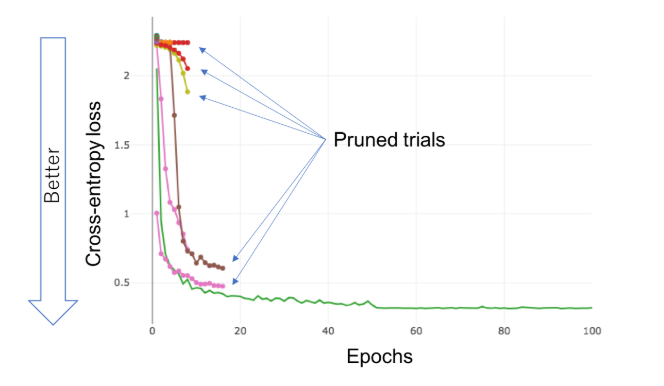

In [0]:
num_rounds = 10000
early_stop = 750
seed = 0
folds=8
cat_features = ['P0_species','P1_species','map']

In [0]:
# Referred https://github.com/pfnet/optuna/blob/master/examples/pruning/lightgbm_integration.py

def fit_lgbm_with_pruning(trial, train, val, devices=(-1,), seed=seed, cat_features=cat_features, num_rounds=num_rounds,early_stop=early_stop):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'auc'
    params = {
        #'num_leaves': trial.suggest_int('num_leaves', 16,1e+4),     # 16~128 정도
        'objective': 'binary',

        'max_depth': trial.suggest_int('max_depth', 8,30),
        #'learning_rate': trial.suggest_discrete_uniform('learning_rate', 1e-4, 0.05, 1e-4),   
        'learning_rate': trial.suggest_uniform('learning_rate',3e-3,3e-2),
        "boosting": "gbdt",#'dart','goss',

        'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 30),   # 1~2     #'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 40),   # 3~6   #'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),

        #"bagging_freq": 5,
        "bagging_fraction": trial.suggest_discrete_uniform('bagging_fraction', 0.1, 0.9, 0.05), 
        "feature_fraction": trial.suggest_discrete_uniform('feature_fraction', 0.1, 0.5, 0.05),  
        #"bagging_fraction": trial.suggest_uniform('bagging_fraction', 0.35, 0.35),
        #"feature_fraction": trial.suggest_uniform('feature_fraction', 0.4, 0.4),  

        "metric": metric,
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed
    early_stop = early_stop
    verbose_eval = 500  # 적합을 할 때, 과정을 보여줄 epoch 단위수 (500으로 하면 500:auc, 1000:auc, 1500:auc, ... 이렇게 보여줌)

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features
                          )
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features
                          )
    watchlist = [d_train, d_valid]

    # Add a callback for pruning.
    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, 'auc', valid_name='valid_1')    
    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop,
                      callbacks=[pruning_callback])

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration,cat_features=cat_features)
    print('#'*25,'이번 trial 중 가장 좋은 스코어는 다음과 같습니다.','#'*25)
    print('best_score', model.best_score)
    log = {'train/auc': model.best_score['training']['auc'],
           'valid/auc': model.best_score['valid_1']['auc']}
    return model, y_pred_valid, log

def objective_with_prune(trial: Trial, fast_check=True,seed=seed,folds=folds,cat_features=cat_features):
    """This method is completely same with previous `objective` method except calling `fit_lgbm_with_pruning`"""
    folds = folds
    seed = seed
    shuffle = True
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = x,y
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()
    print('='*100)
    print('='*100)
    cat_features = cat_features
    print('cat_features : ', cat_features)

    models0 = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
        model, y_pred_valid, log = fit_lgbm_with_pruning(trial, train_data, valid_data, cat_features=cat_features,
                                                         num_rounds=num_rounds)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models0.append(model)
        gc.collect()
        valid_score += log["valid/auc"]
        if fast_check:
            break
    valid_score /= len(models0)
    return valid_score

In [0]:
#study = optuna.create_study(direction='maximize')   # auc니까 최대를 목표로
#study.optimize(objective_with_prune, n_trials=50)
#study.optimize(lambda trial: objective_with_prune(trial, arg0=1, arg1=2), n_trials=100)

study = optuna.create_study(direction='maximize',pruner=optuna.pruners.MedianPruner(n_warmup_steps=20)) # 20차례는 적어도 지켜보고(warmup), 중앙값을 확인해 Prune 할지 결정
study.optimize(objective_with_prune, n_trials=120)

cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.827169	valid_1's auc: 0.725931
[1000]	training's auc: 0.891911	valid_1's auc: 0.736046
[1500]	training's auc: 0.929881	valid_1's auc: 0.739082
[2000]	training's auc: 0.95453	valid_1's auc: 0.740288
[2500]	training's auc: 0.970588	valid_1's auc: 0.740265
[3000]	training's auc: 0.980998	valid_1's auc: 0.741035
[3500]	training's auc: 0.987791	valid_1's auc: 0.7411
[4000]	training's auc: 0.992289	valid_1's auc: 0.740885
Early stopping, best iteration is:
[3676]	training's auc: 0.98962	valid_1's auc: 0.741374
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.989620390089973}, 'valid_1': {'auc': 0.7413741862679648}})


[I 2020-04-08 04:29:31,411] Finished trial#0 resulted in value: 0.7413741862679648. Current best value is 0.7413741862679648 with parameters: {'max_depth': 22, 'learning_rate': 0.0183041084206884, 'lambda_l1': 5.013046912126738, 'lambda_l2': 6.697955181542792, 'bagging_fraction': 0.85, 'feature_fraction': 0.5}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.815728	valid_1's auc: 0.7235
[1000]	training's auc: 0.873304	valid_1's auc: 0.732604
[1500]	training's auc: 0.910205	valid_1's auc: 0.735432
[2000]	training's auc: 0.935622	valid_1's auc: 0.736651
[2500]	training's auc: 0.953554	valid_1's auc: 0.736795
[3000]	training's auc: 0.966586	valid_1's auc: 0.735524
Early stopping, best iteration is:
[2352]	training's auc: 0.948861	valid_1's auc: 0.737065
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9488612177079152}, 'valid_1': {'auc': 0.7370653459441325}})


[I 2020-04-08 04:35:31,860] Finished trial#1 resulted in value: 0.7370653459441325. Current best value is 0.7413741862679648 with parameters: {'max_depth': 22, 'learning_rate': 0.0183041084206884, 'lambda_l1': 5.013046912126738, 'lambda_l2': 6.697955181542792, 'bagging_fraction': 0.85, 'feature_fraction': 0.5}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.825802	valid_1's auc: 0.725151
[1000]	training's auc: 0.88682	valid_1's auc: 0.731993
[1500]	training's auc: 0.923778	valid_1's auc: 0.733936
[2000]	training's auc: 0.948337	valid_1's auc: 0.734617
[2500]	training's auc: 0.965073	valid_1's auc: 0.735064
[3000]	training's auc: 0.976525	valid_1's auc: 0.734744
Early stopping, best iteration is:
[2686]	training's auc: 0.969925	valid_1's auc: 0.735444
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9699246907288135}, 'valid_1': {'auc': 0.7354443205655204}})


[I 2020-04-08 04:43:04,580] Finished trial#2 resulted in value: 0.7354443205655204. Current best value is 0.7413741862679648 with parameters: {'max_depth': 22, 'learning_rate': 0.0183041084206884, 'lambda_l1': 5.013046912126738, 'lambda_l2': 6.697955181542792, 'bagging_fraction': 0.85, 'feature_fraction': 0.5}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.799497	valid_1's auc: 0.717055
[1000]	training's auc: 0.859438	valid_1's auc: 0.730994
[1500]	training's auc: 0.89883	valid_1's auc: 0.736452
[2000]	training's auc: 0.926649	valid_1's auc: 0.738182
[2500]	training's auc: 0.946436	valid_1's auc: 0.739401
[3000]	training's auc: 0.960914	valid_1's auc: 0.739933
[3500]	training's auc: 0.971463	valid_1's auc: 0.740365
[4000]	training's auc: 0.979381	valid_1's auc: 0.741283
[4500]	training's auc: 0.985136	valid_1's auc: 0.741817
[5000]	training's auc: 0.989221	valid_1's auc: 0.742346
[5500]	training's auc: 0.992287	valid_1's auc: 0.74253
[6000]	training's auc: 0.994348	valid_1's auc: 0.742594
[6500]	training's auc: 0.995904	valid_1's auc: 0.742674
[7000]	training's auc: 0.997065	valid_1's auc: 0.742966
[7500]	training's auc: 0.997851	valid_1's auc: 0.742959
[8000]	trai

[I 2020-04-08 05:00:28,968] Finished trial#3 resulted in value: 0.74336069212548. Current best value is 0.74336069212548 with parameters: {'max_depth': 26, 'learning_rate': 0.012310549621270001, 'lambda_l1': 1.7335971762309976, 'lambda_l2': 4.113294082024281, 'bagging_fraction': 0.7000000000000001, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.7583	valid_1's auc: 0.703031
[1000]	training's auc: 0.802026	valid_1's auc: 0.718879
[1500]	training's auc: 0.834469	valid_1's auc: 0.726541
[2000]	training's auc: 0.860076	valid_1's auc: 0.731076
[2500]	training's auc: 0.880904	valid_1's auc: 0.734082
[3000]	training's auc: 0.898158	valid_1's auc: 0.735605
[3500]	training's auc: 0.912356	valid_1's auc: 0.736855
[4000]	training's auc: 0.924405	valid_1's auc: 0.737591
[4500]	training's auc: 0.934777	valid_1's auc: 0.738281
[5000]	training's auc: 0.94372	valid_1's auc: 0.738307
[5500]	training's auc: 0.951493	valid_1's auc: 0.73856
[6000]	training's auc: 0.958204	valid_1's auc: 0.738463
Early stopping, best iteration is:
[5286]	training's auc: 0.948278	valid_1's auc: 0.738615
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_s

[I 2020-04-08 05:18:05,428] Finished trial#4 resulted in value: 0.7386146985167288. Current best value is 0.74336069212548 with parameters: {'max_depth': 26, 'learning_rate': 0.012310549621270001, 'lambda_l1': 1.7335971762309976, 'lambda_l2': 4.113294082024281, 'bagging_fraction': 0.7000000000000001, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 05:18:28,742] Setting status of trial#5 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 05:18:48,435] Setting status of trial#6 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 05:19:08,831] Setting status of trial#7 as TrialState.PRUNED. Trial was pruned at iteration 28.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 05:19:28,868] Setting status of trial#8 as TrialState.PRUNED. Trial was pruned at iteration 22.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 05:19:47,829] Setting status of trial#9 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 05:20:06,171] Setting status of trial#10 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.849731	valid_1's auc: 0.725967
[1000]	training's auc: 0.919286	valid_1's auc: 0.733063
[1500]	training's auc: 0.95693	valid_1's auc: 0.736409
[2000]	training's auc: 0.977248	valid_1's auc: 0.738457
[2500]	training's auc: 0.988163	valid_1's auc: 0.739396
[3000]	training's auc: 0.993799	valid_1's auc: 0.74008


[I 2020-04-08 05:28:32,493] Setting status of trial#11 as TrialState.PRUNED. Trial was pruned at iteration 3436.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 05:28:52,870] Setting status of trial#12 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 05:29:31,430] Setting status of trial#13 as TrialState.PRUNED. Trial was pruned at iteration 115.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 05:29:50,074] Setting status of trial#14 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.871469	valid_1's auc: 0.730106
[1000]	training's auc: 0.938746	valid_1's auc: 0.737092
[1500]	training's auc: 0.97049	valid_1's auc: 0.739834
[2000]	training's auc: 0.98581	valid_1's auc: 0.74165
[2500]	training's auc: 0.993196	valid_1's auc: 0.741357
[3000]	training's auc: 0.996884	valid_1's auc: 0.742331
[3500]	training's auc: 0.998584	valid_1's auc: 0.741943
Early stopping, best iteration is:
[2894]	training's auc: 0.996312	valid_1's auc: 0.742536
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9963120173486423}, 'valid_1': {'auc': 0.7425363701366697}})


[I 2020-04-08 05:37:38,017] Finished trial#15 resulted in value: 0.7425363701366697. Current best value is 0.74336069212548 with parameters: {'max_depth': 26, 'learning_rate': 0.012310549621270001, 'lambda_l1': 1.7335971762309976, 'lambda_l2': 4.113294082024281, 'bagging_fraction': 0.7000000000000001, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.872132	valid_1's auc: 0.73176
[1000]	training's auc: 0.938544	valid_1's auc: 0.737305
[1500]	training's auc: 0.970092	valid_1's auc: 0.739139
[2000]	training's auc: 0.98527	valid_1's auc: 0.739681
[2500]	training's auc: 0.992784	valid_1's auc: 0.740817
[3000]	training's auc: 0.996591	valid_1's auc: 0.740092
Early stopping, best iteration is:
[2416]	training's auc: 0.991874	valid_1's auc: 0.741267
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9918735566073391}, 'valid_1': {'auc': 0.7412672700963432}})


[I 2020-04-08 05:44:42,861] Finished trial#16 resulted in value: 0.7412672700963432. Current best value is 0.74336069212548 with parameters: {'max_depth': 26, 'learning_rate': 0.012310549621270001, 'lambda_l1': 1.7335971762309976, 'lambda_l2': 4.113294082024281, 'bagging_fraction': 0.7000000000000001, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 05:45:02,227] Setting status of trial#17 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 05:45:22,477] Setting status of trial#18 as TrialState.PRUNED. Trial was pruned at iteration 26.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.863031	valid_1's auc: 0.732063
[1000]	training's auc: 0.929584	valid_1's auc: 0.739176
[1500]	training's auc: 0.962631	valid_1's auc: 0.741069
[2000]	training's auc: 0.980072	valid_1's auc: 0.741229
[2500]	training's auc: 0.9893	valid_1's auc: 0.741027
[3000]	training's auc: 0.994469	valid_1's auc: 0.741477
[3500]	training's auc: 0.997031	valid_1's auc: 0.742242
[4000]	training's auc: 0.99838	valid_1's auc: 0.742269
[4500]	training's auc: 0.999179	valid_1's auc: 0.74176
Early stopping, best iteration is:
[4094]	training's auc: 0.998572	valid_1's auc: 0.742543
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9985722338714236}, 'valid_1': {'auc': 0.742543486585494}})


[I 2020-04-08 05:56:16,496] Finished trial#19 resulted in value: 0.742543486585494. Current best value is 0.74336069212548 with parameters: {'max_depth': 26, 'learning_rate': 0.012310549621270001, 'lambda_l1': 1.7335971762309976, 'lambda_l2': 4.113294082024281, 'bagging_fraction': 0.7000000000000001, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 05:56:36,086] Setting status of trial#20 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.879445	valid_1's auc: 0.73187
[1000]	training's auc: 0.945047	valid_1's auc: 0.737965
[1500]	training's auc: 0.974901	valid_1's auc: 0.739408
[2000]	training's auc: 0.988607	valid_1's auc: 0.740408
[2500]	training's auc: 0.994877	valid_1's auc: 0.739887
Early stopping, best iteration is:
[1847]	training's auc: 0.985521	valid_1's auc: 0.741178
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9855213599674124}, 'valid_1': {'auc': 0.741177636729009}})


[I 2020-04-08 06:02:52,149] Finished trial#21 resulted in value: 0.741177636729009. Current best value is 0.74336069212548 with parameters: {'max_depth': 26, 'learning_rate': 0.012310549621270001, 'lambda_l1': 1.7335971762309976, 'lambda_l2': 4.113294082024281, 'bagging_fraction': 0.7000000000000001, 'feature_fraction': 0.25}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:03:11,886] Setting status of trial#22 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.861634	valid_1's auc: 0.730945
[1000]	training's auc: 0.929565	valid_1's auc: 0.738272
[1500]	training's auc: 0.964	valid_1's auc: 0.741468
[2000]	training's auc: 0.981529	valid_1's auc: 0.742558
[2500]	training's auc: 0.990748	valid_1's auc: 0.74443
[3000]	training's auc: 0.995197	valid_1's auc: 0.744961
[3500]	training's auc: 0.997584	valid_1's auc: 0.744309
Early stopping, best iteration is:
[3121]	training's auc: 0.995932	valid_1's auc: 0.74523
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9959321226723348}, 'valid_1': {'auc': 0.7452304543344257}})


[I 2020-04-08 06:12:25,589] Finished trial#23 resulted in value: 0.7452304543344257. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:12:46,099] Setting status of trial#24 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:13:05,632] Setting status of trial#25 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:13:27,672] Setting status of trial#26 as TrialState.PRUNED. Trial was pruned at iteration 32.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:13:46,809] Setting status of trial#27 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:14:06,339] Setting status of trial#28 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:14:25,676] Setting status of trial#29 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:14:45,309] Setting status of trial#30 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.866718	valid_1's auc: 0.731573
[1000]	training's auc: 0.934656	valid_1's auc: 0.738047
[1500]	training's auc: 0.967219	valid_1's auc: 0.740204
[2000]	training's auc: 0.983739	valid_1's auc: 0.741461
[2500]	training's auc: 0.99194	valid_1's auc: 0.740857
Early stopping, best iteration is:
[1985]	training's auc: 0.983384	valid_1's auc: 0.741612
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9833835383154966}, 'valid_1': {'auc': 0.7416124178643199}})


[I 2020-04-08 06:21:50,098] Finished trial#31 resulted in value: 0.7416124178643199. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:22:14,097] Setting status of trial#32 as TrialState.PRUNED. Trial was pruned at iteration 22.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:22:33,871] Setting status of trial#33 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:22:54,869] Setting status of trial#34 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:23:14,187] Setting status of trial#35 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:23:33,668] Setting status of trial#36 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:23:52,850] Setting status of trial#37 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:24:12,148] Setting status of trial#38 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:24:31,478] Setting status of trial#39 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:24:51,209] Setting status of trial#40 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.868191	valid_1's auc: 0.733976
[1000]	training's auc: 0.934915	valid_1's auc: 0.738955
[1500]	training's auc: 0.967578	valid_1's auc: 0.740532
[2000]	training's auc: 0.983961	valid_1's auc: 0.74094
[2500]	training's auc: 0.992055	valid_1's auc: 0.741942
[3000]	training's auc: 0.996176	valid_1's auc: 0.742525
[3500]	training's auc: 0.99813	valid_1's auc: 0.742364
Early stopping, best iteration is:
[3037]	training's auc: 0.996396	valid_1's auc: 0.74271
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9963955075304777}, 'valid_1': {'auc': 0.7427095370580601}})


[I 2020-04-08 06:34:39,683] Finished trial#41 resulted in value: 0.7427095370580601. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.86904	valid_1's auc: 0.733441
[1000]	training's auc: 0.935423	valid_1's auc: 0.738673
[1500]	training's auc: 0.967795	valid_1's auc: 0.74062
[2000]	training's auc: 0.984145	valid_1's auc: 0.741123
[2500]	training's auc: 0.992066	valid_1's auc: 0.74123
Early stopping, best iteration is:
[2226]	training's auc: 0.988495	valid_1's auc: 0.741943
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9884953074209664}, 'valid_1': {'auc': 0.7419431632953902}})


[I 2020-04-08 06:43:31,251] Finished trial#42 resulted in value: 0.7419431632953902. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:43:52,213] Setting status of trial#43 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.868445	valid_1's auc: 0.732304


[I 2020-04-08 06:46:23,448] Setting status of trial#44 as TrialState.PRUNED. Trial was pruned at iteration 608.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:46:43,615] Setting status of trial#45 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.866239	valid_1's auc: 0.733178
[1000]	training's auc: 0.932485	valid_1's auc: 0.738329
[1500]	training's auc: 0.965621	valid_1's auc: 0.740104
[2000]	training's auc: 0.98244	valid_1's auc: 0.740601
[2500]	training's auc: 0.991169	valid_1's auc: 0.740183


[I 2020-04-08 06:54:43,380] Setting status of trial#46 as TrialState.PRUNED. Trial was pruned at iteration 2549.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:55:13,502] Setting status of trial#47 as TrialState.PRUNED. Trial was pruned at iteration 58.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:55:33,244] Setting status of trial#48 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:55:52,958] Setting status of trial#49 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:56:12,757] Setting status of trial#50 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:56:32,561] Setting status of trial#51 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 06:56:54,296] Setting status of trial#52 as TrialState.PRUNED. Trial was pruned at iteration 29.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.866916	valid_1's auc: 0.732427
[1000]	training's auc: 0.932711	valid_1's auc: 0.739355
[1500]	training's auc: 0.965086	valid_1's auc: 0.740699
[2000]	training's auc: 0.982005	valid_1's auc: 0.741539
[2500]	training's auc: 0.990773	valid_1's auc: 0.741884
[3000]	training's auc: 0.995308	valid_1's auc: 0.742996
[3500]	training's auc: 0.997696	valid_1's auc: 0.743118
Early stopping, best iteration is:
[3073]	training's auc: 0.995771	valid_1's auc: 0.743488
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9957708369427586}, 'valid_1': {'auc': 0.7434881104472858}})


[I 2020-04-08 07:07:58,479] Finished trial#53 resulted in value: 0.7434881104472858. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:08:20,767] Setting status of trial#54 as TrialState.PRUNED. Trial was pruned at iteration 22.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:08:41,015] Setting status of trial#55 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:09:01,368] Setting status of trial#56 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:09:21,439] Setting status of trial#57 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:09:42,431] Setting status of trial#58 as TrialState.PRUNED. Trial was pruned at iteration 25.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:10:02,392] Setting status of trial#59 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:10:22,316] Setting status of trial#60 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.874791	valid_1's auc: 0.732227


[I 2020-04-08 07:12:45,350] Setting status of trial#61 as TrialState.PRUNED. Trial was pruned at iteration 605.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.879029	valid_1's auc: 0.73289
[1000]	training's auc: 0.945738	valid_1's auc: 0.739093
[1500]	training's auc: 0.975838	valid_1's auc: 0.741224
[2000]	training's auc: 0.989377	valid_1's auc: 0.742875
[2500]	training's auc: 0.995328	valid_1's auc: 0.743038
[3000]	training's auc: 0.998008	valid_1's auc: 0.743856
[3500]	training's auc: 0.999113	valid_1's auc: 0.744244
[4000]	training's auc: 0.99961	valid_1's auc: 0.743753
Early stopping, best iteration is:
[3334]	training's auc: 0.998829	valid_1's auc: 0.744723
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9988285650148595}, 'valid_1': {'auc': 0.7447229837575527}})


[I 2020-04-08 07:24:42,558] Finished trial#62 resulted in value: 0.7447229837575527. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.86982	valid_1's auc: 0.732173


[I 2020-04-08 07:27:08,885] Setting status of trial#63 as TrialState.PRUNED. Trial was pruned at iteration 609.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.86952	valid_1's auc: 0.734843
[1000]	training's auc: 0.935989	valid_1's auc: 0.739535
[1500]	training's auc: 0.967742	valid_1's auc: 0.740301


[I 2020-04-08 07:32:54,646] Setting status of trial#64 as TrialState.PRUNED. Trial was pruned at iteration 1721.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:33:19,427] Setting status of trial#65 as TrialState.PRUNED. Trial was pruned at iteration 38.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:33:42,471] Setting status of trial#66 as TrialState.PRUNED. Trial was pruned at iteration 32.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:35:31,036] Setting status of trial#67 as TrialState.PRUNED. Trial was pruned at iteration 409.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:35:55,248] Setting status of trial#68 as TrialState.PRUNED. Trial was pruned at iteration 36.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:36:17,898] Setting status of trial#69 as TrialState.PRUNED. Trial was pruned at iteration 32.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.867519	valid_1's auc: 0.734506
[1000]	training's auc: 0.935144	valid_1's auc: 0.740255
[1500]	training's auc: 0.968392	valid_1's auc: 0.740698
[2000]	training's auc: 0.984847	valid_1's auc: 0.742288
[2500]	training's auc: 0.992627	valid_1's auc: 0.742641
[3000]	training's auc: 0.996564	valid_1's auc: 0.742389
Early stopping, best iteration is:
[2744]	training's auc: 0.994896	valid_1's auc: 0.742995
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9948964599346913}, 'valid_1': {'auc': 0.742995042207319}})


[I 2020-04-08 07:47:12,178] Finished trial#70 resulted in value: 0.742995042207319. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:49:03,489] Setting status of trial#71 as TrialState.PRUNED. Trial was pruned at iteration 426.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:49:24,302] Setting status of trial#72 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:49:52,569] Setting status of trial#73 as TrialState.PRUNED. Trial was pruned at iteration 55.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:50:20,519] Setting status of trial#74 as TrialState.PRUNED. Trial was pruned at iteration 55.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:50:49,425] Setting status of trial#75 as TrialState.PRUNED. Trial was pruned at iteration 58.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:51:13,230] Setting status of trial#76 as TrialState.PRUNED. Trial was pruned at iteration 35.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:51:36,853] Setting status of trial#77 as TrialState.PRUNED. Trial was pruned at iteration 35.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:51:59,420] Setting status of trial#78 as TrialState.PRUNED. Trial was pruned at iteration 31.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:52:23,138] Setting status of trial#79 as TrialState.PRUNED. Trial was pruned at iteration 36.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 07:52:43,711] Setting status of trial#80 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.871072	valid_1's auc: 0.734948
[1000]	training's auc: 0.937017	valid_1's auc: 0.740311
[1500]	training's auc: 0.968762	valid_1's auc: 0.742719
[2000]	training's auc: 0.984567	valid_1's auc: 0.743734
[2500]	training's auc: 0.992511	valid_1's auc: 0.743009
Early stopping, best iteration is:
[1902]	training's auc: 0.982215	valid_1's auc: 0.744042
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9822147864123583}, 'valid_1': {'auc': 0.7440420073807741}})


[I 2020-04-08 08:01:26,536] Finished trial#81 resulted in value: 0.7440420073807741. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 08:01:52,945] Setting status of trial#82 as TrialState.PRUNED. Trial was pruned at iteration 39.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.871547	valid_1's auc: 0.732328


[I 2020-04-08 08:04:12,021] Setting status of trial#83 as TrialState.PRUNED. Trial was pruned at iteration 542.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 08:05:26,185] Setting status of trial#84 as TrialState.PRUNED. Trial was pruned at iteration 246.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 08:05:50,369] Setting status of trial#85 as TrialState.PRUNED. Trial was pruned at iteration 34.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 08:06:13,102] Setting status of trial#86 as TrialState.PRUNED. Trial was pruned at iteration 32.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 08:07:25,004] Setting status of trial#87 as TrialState.PRUNED. Trial was pruned at iteration 243.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.86452	valid_1's auc: 0.733508
[1000]	training's auc: 0.93043	valid_1's auc: 0.741437
[1500]	training's auc: 0.96337	valid_1's auc: 0.741978
[2000]	training's auc: 0.980753	valid_1's auc: 0.74179
[2500]	training's auc: 0.990115	valid_1's auc: 0.742511
[3000]	training's auc: 0.994878	valid_1's auc: 0.74259
[3500]	training's auc: 0.997394	valid_1's auc: 0.743103
[4000]	training's auc: 0.998645	valid_1's auc: 0.743038
[4500]	training's auc: 0.99928	valid_1's auc: 0.743557
[5000]	training's auc: 0.999601	valid_1's auc: 0.743488
[5500]	training's auc: 0.999785	valid_1's auc: 0.742984
Early stopping, best iteration is:
[4877]	training's auc: 0.999535	valid_1's auc: 0.743901
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.99

[I 2020-04-08 08:25:31,830] Finished trial#88 resulted in value: 0.7439010339183506. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 08:25:58,170] Setting status of trial#89 as TrialState.PRUNED. Trial was pruned at iteration 32.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 08:26:21,736] Setting status of trial#90 as TrialState.PRUNED. Trial was pruned at iteration 29.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.865386	valid_1's auc: 0.732339
[1000]	training's auc: 0.932239	valid_1's auc: 0.739841
[1500]	training's auc: 0.964961	valid_1's auc: 0.741153
[2000]	training's auc: 0.9819	valid_1's auc: 0.741412
[2500]	training's auc: 0.990946	valid_1's auc: 0.741785
Early stopping, best iteration is:
[2159]	training's auc: 0.985345	valid_1's auc: 0.742105
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9853449576985154}, 'valid_1': {'auc': 0.7421054861042865}})


[I 2020-04-08 08:36:34,536] Finished trial#91 resulted in value: 0.7421054861042865. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.868038	valid_1's auc: 0.734052
[1000]	training's auc: 0.934242	valid_1's auc: 0.739786


[I 2020-04-08 08:41:59,156] Setting status of trial#92 as TrialState.PRUNED. Trial was pruned at iteration 1402.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 08:42:29,580] Setting status of trial#93 as TrialState.PRUNED. Trial was pruned at iteration 58.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.870823	valid_1's auc: 0.733191
[1000]	training's auc: 0.936996	valid_1's auc: 0.740257
[1500]	training's auc: 0.968942	valid_1's auc: 0.7435
[2000]	training's auc: 0.984604	valid_1's auc: 0.742991
Early stopping, best iteration is:
[1707]	training's auc: 0.976828	valid_1's auc: 0.743773
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9768279253349175}, 'valid_1': {'auc': 0.7437727684002562}})


[I 2020-04-08 08:51:30,162] Finished trial#94 resulted in value: 0.7437727684002562. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.867409	valid_1's auc: 0.733454
[1000]	training's auc: 0.932879	valid_1's auc: 0.739515
[1500]	training's auc: 0.965101	valid_1's auc: 0.740785


[I 2020-04-08 08:59:03,287] Setting status of trial#95 as TrialState.PRUNED. Trial was pruned at iteration 1950.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 08:59:30,770] Setting status of trial#96 as TrialState.PRUNED. Trial was pruned at iteration 39.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 08:59:55,563] Setting status of trial#97 as TrialState.PRUNED. Trial was pruned at iteration 35.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:00:18,081] Setting status of trial#98 as TrialState.PRUNED. Trial was pruned at iteration 25.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:01:21,323] Setting status of trial#99 as TrialState.PRUNED. Trial was pruned at iteration 187.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:01:46,062] Setting status of trial#100 as TrialState.PRUNED. Trial was pruned at iteration 33.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.868585	valid_1's auc: 0.734039
[1000]	training's auc: 0.935347	valid_1's auc: 0.739773
[1500]	training's auc: 0.968187	valid_1's auc: 0.741833
[2000]	training's auc: 0.984218	valid_1's auc: 0.743349
[2500]	training's auc: 0.992369	valid_1's auc: 0.743878
[3000]	training's auc: 0.996361	valid_1's auc: 0.744039
[3500]	training's auc: 0.998256	valid_1's auc: 0.74409
Early stopping, best iteration is:
[2915]	training's auc: 0.995876	valid_1's auc: 0.744293
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9958755739530769}, 'valid_1': {'auc': 0.7442929469214581}})


[I 2020-04-08 09:15:07,214] Finished trial#101 resulted in value: 0.7442929469214581. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:15:39,030] Setting status of trial#102 as TrialState.PRUNED. Trial was pruned at iteration 61.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:16:09,605] Setting status of trial#103 as TrialState.PRUNED. Trial was pruned at iteration 57.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:17:12,711] Setting status of trial#104 as TrialState.PRUNED. Trial was pruned at iteration 187.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.879506	valid_1's auc: 0.733606


[I 2020-04-08 09:20:23,230] Setting status of trial#105 as TrialState.PRUNED. Trial was pruned at iteration 632.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:21:40,465] Setting status of trial#106 as TrialState.PRUNED. Trial was pruned at iteration 240.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:22:04,984] Setting status of trial#107 as TrialState.PRUNED. Trial was pruned at iteration 32.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:22:31,941] Setting status of trial#108 as TrialState.PRUNED. Trial was pruned at iteration 39.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:23:11,595] Setting status of trial#109 as TrialState.PRUNED. Trial was pruned at iteration 90.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:23:34,109] Setting status of trial#110 as TrialState.PRUNED. Trial was pruned at iteration 25.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:23:59,002] Setting status of trial#111 as TrialState.PRUNED. Trial was pruned at iteration 35.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:26:08,277] Setting status of trial#112 as TrialState.PRUNED. Trial was pruned at iteration 446.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:26:30,226] Setting status of trial#113 as TrialState.PRUNED. Trial was pruned at iteration 21.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:28:50,868] Setting status of trial#114 as TrialState.PRUNED. Trial was pruned at iteration 489.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:29:15,778] Setting status of trial#115 as TrialState.PRUNED. Trial was pruned at iteration 32.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:29:41,044] Setting status of trial#116 as TrialState.PRUNED. Trial was pruned at iteration 36.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:30:05,239] Setting status of trial#117 as TrialState.PRUNED. Trial was pruned at iteration 32.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.874187	valid_1's auc: 0.733998
[1000]	training's auc: 0.941763	valid_1's auc: 0.739966
[1500]	training's auc: 0.972986	valid_1's auc: 0.741174
[2000]	training's auc: 0.987685	valid_1's auc: 0.741859
[2500]	training's auc: 0.994568	valid_1's auc: 0.743598
[3000]	training's auc: 0.997616	valid_1's auc: 0.744117
[3500]	training's auc: 0.998979	valid_1's auc: 0.744153
Early stopping, best iteration is:
[2846]	training's auc: 0.996916	valid_1's auc: 0.744369
######################### 이번 trial 중 가장 좋은 스코어는 다음과 같습니다. #########################
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9969159355418039}, 'valid_1': {'auc': 0.7443693640266901}})


[I 2020-04-08 09:43:25,663] Finished trial#118 resulted in value: 0.7443693640266901. Current best value is 0.7452304543344257 with parameters: {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}.


cat_features :  ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.


[I 2020-04-08 09:43:52,023] Setting status of trial#119 as TrialState.PRUNED. Trial was pruned at iteration 38.


In [0]:
# 8 Fold
# Check study history to get best hyperparameters
print('Best trial: score {}, params {}'.format(study.best_value, study.best_params))

#trials_df = study.trials_dataframe()
#trials_df


Best trial: score 0.7452304543344257, params {'max_depth': 12, 'learning_rate': 0.026530522850076628, 'lambda_l1': 2.1926797335917727, 'lambda_l2': 0.007593193782932772, 'bagging_fraction': 0.55, 'feature_fraction': 0.1}


In [0]:
### Visualize study history to analayze the hyperparams-performance relationship

#optuna.visualization.plot_optimization_history(study)   #Optimization history
optuna.visualization.plot_intermediate_values(study)   #Visualize pruning history
#optuna.visualization.plot_slice(study)    #Visualize plot slice
#optuna.visualization.plot_contour(study)    #Visualize plot contour (변수들 pairwise plot => 두 모수의 상호작용효과 확인)
#optuna.visualization.plot_parallel_coordinate(study)   #Visualize parallel_coordinate

#출처 : https://github.com/pfnet/optuna/tree/master/examples/visualization


In [0]:
### Visualize study history to analayze the hyperparams-performance relationship

#optuna.visualization.plot_optimization_history(study)   #Optimization history
optuna.visualization.plot_intermediate_values(study)   #Visualize pruning history
#optuna.visualization.plot_slice(study)    #Visualize plot slice
#optuna.visualization.plot_contour(study)    #Visualize plot contour (변수들 pairwise plot => 두 모수의 상호작용효과 확인)
#optuna.visualization.plot_parallel_coordinate(study)   #Visualize parallel_coordinate

#출처 : https://github.com/pfnet/optuna/tree/master/examples/visualization


## 최적화된 모수의 모델 적합시키고 변수중요도 Plot 확인, pred값 생성

In [0]:
print(x.shape)

(38872, 5948)


In [0]:

def objective(trial: Trial, fast_check=True,  return_info=False,seed=seed,folds=folds,cat_features = cat_features):
    folds = folds
    seed = seed
    shuffle = True
    kf = KFold(n_splits=folds, shuffle=shuffle, random_state=seed)

    X_train, y_train = x,y
    y_valid_pred_total = np.zeros(X_train.shape[0])
    gc.collect()

    cat_features = cat_features
    print('cat_features', cat_features)

    models = []
    valid_score = 0
    for train_idx, valid_idx in kf.split(X_train, y_train):
        train_data = X_train.iloc[train_idx,:], y_train[train_idx]
        valid_data = X_train.iloc[valid_idx,:], y_train[valid_idx]

        print('train', len(train_idx), 'valid', len(valid_idx))
    #     model, y_pred_valid, log = fit_cb(train_data, valid_data, cat_features=cat_features, devices=[0,])
        model, y_pred_valid, log = fit_lgbm(trial, train_data, valid_data, cat_features=cat_features,
                                            num_rounds=num_rounds)
        y_valid_pred_total[valid_idx] = y_pred_valid
        models.append(model)
        gc.collect()
        valid_score += log["valid/auc"]
        if fast_check:
            break
    valid_score /= len(models)
    if return_info:
        return valid_score, models, y_pred_valid, y_train
    else:
        return valid_score

def fit_lgbm(trial, train, val, devices=(-1,), seed=seed, num_rounds=num_rounds,early_stop=early_stop,cat_features = cat_features):
    """Train Light GBM model"""
    X_train, y_train = train
    X_valid, y_valid = val
    metric = 'auc'
    params = {
        #'num_leaves': trial.suggest_int('num_leaves', 8, 1024),
        'objective': 'binary',
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'learning_rate': trial.suggest_uniform('learning_rate', 1e-10, 0.1),
        "boosting": "gbdt",#'dart','goss'
        #'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        #'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'lambda_l1': trial.suggest_uniform('lambda_l1', 0, 50), 
        'lambda_l2': trial.suggest_uniform('lambda_l2', 0, 50),
        #"bagging_freq": 5,
        "bagging_fraction": trial.suggest_uniform('bagging_fraction', 0, 1),
        "feature_fraction": trial.suggest_uniform('feature_fraction', 0, 1),
        "metric": metric,
        "verbosity": -1,
    }
    device = devices[0]
    if device == -1:
        # use cpu
        pass
    else:
        # use gpu
        print(f'using gpu device_id {device}...')
        params.update({'device': 'gpu', 'gpu_device_id': device})

    params['seed'] = seed

    early_stop = early_stop
    verbose_eval = 500

    d_train = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_features)
    d_valid = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_features)
    watchlist = [d_train, d_valid]

    print('training LGB:')
    model = lgb.train(params,
                      train_set=d_train,
                      num_boost_round=num_rounds,
                      valid_sets=watchlist,
                      verbose_eval=verbose_eval,
                      early_stopping_rounds=early_stop)

    # predictions
    y_pred_valid = model.predict(X_valid, num_iteration=model.best_iteration)
    
    print('best_score', model.best_score)
    log = {'train/auc': model.best_score['training']['auc'],
           'valid/auc': model.best_score['valid_1']['auc']}
    return model, y_pred_valid, log

####################################### 모델 불러오기 ###################################
valid_score, models0, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(study.best_params), fast_check=False, return_info=True   )

#best_params = {'max_depth': 28, 'learning_rate': 0.025670843196156163, 'lambda_l1': 1.4356189976639242, 'lambda_l2': 20.693747661310503, 'bagging_fraction': 0.35, 'feature_fraction': 0.30000000000000004}
#valid_score, models0, y_pred_valid, y_train = objective(optuna.trial.FixedTrial(best_params), fast_check=False, return_info=True   )


cat_features ['P0_species', 'P1_species', 'map']
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.861634	valid_1's auc: 0.730945
[1000]	training's auc: 0.929565	valid_1's auc: 0.738272
[1500]	training's auc: 0.964	valid_1's auc: 0.741468
[2000]	training's auc: 0.981529	valid_1's auc: 0.742558
[2500]	training's auc: 0.990748	valid_1's auc: 0.74443
[3000]	training's auc: 0.995197	valid_1's auc: 0.744961
[3500]	training's auc: 0.997584	valid_1's auc: 0.744309
Early stopping, best iteration is:
[3121]	training's auc: 0.995932	valid_1's auc: 0.74523
best_score defaultdict(<class 'dict'>, {'training': {'auc': 0.9959321226723348}, 'valid_1': {'auc': 0.7452304543344257}})
train 34013 valid 4859
training LGB:
Training until validation scores don't improve for 750 rounds.
[500]	training's auc: 0.862308	valid_1's auc: 0.730472
[1000]	training's auc: 0.929968	valid_1's auc: 0.735919
[1500]	training's auc: 0.963861	valid_1's

In [0]:
import matplotlib.pyplot as plt

################################ 변수중요도 플랏 ############################
def plot_feature_importance(model):
    importance_df = pd.DataFrame(model.feature_importance(),
                                 index=x.columns,
                                 columns=['importance']).iloc[:200,:].sort_values('importance')
    fig, ax = plt.subplots(figsize=(16, 70))
    importance_df.plot.barh(ax=ax)
    fig.show()
plot_feature_importance(models0[1])
#plot_feature_importance(models1[1])
#plot_feature_importance(models2[1])

## 제출 파일 생성

In [0]:
print(no_missing_train.drop(bad_features,axis=1).copy().shape)

In [0]:
test_Ability_Raw.index = no_missing_test.index
test_Ability.index = no_missing_test.index
test_Selection_Raw.index =  no_missing_test.index
test_Selection.index = no_missing_test.index
test_Right_Raw.index =  no_missing_test.index
test_Right.index = no_missing_test.index

In [0]:

test_X = pd.concat([no_missing_test,test_Ability_Raw,test_Ability,test_Selection_Raw,test_Selection, test_Right_Raw, test_Right],axis=1).drop(bad_features,axis=1).copy()
print(test_X.shape)
preds = []
for model in models0:
    pred = model.predict(test_X)#predict_proba    [:, 1]
    preds.append(pred)
pred = np.mean(preds, axis=0)

submission = pd.read_csv('sample_submission.csv', index_col=0)
submission['winner'] = submission['winner'] + pred
submission.to_csv('제출/모델링38_8FOLD늘림_RawAbility_RawSelection_RawRight_colname구분_데이터전체에permutation.csv', encoding='utf8')
submission.head()

(16787, 5948)


,winner
game_id,
38872,0.419026
38873,0.664933
38874,0.390175
38875,0.165264
38876,0.604254
